# Survival analysis

Make a dictionary where we have a table for each cancer type that's ready to plug into the plotter. Format: One column of days until last contact or death (duration col), on column of vital status (event col), and a column of true/false for each event (attribute).

Then plot for each cancer type.

In [1]:
import pandas as pd
import numpy as np
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import os
import statsmodels.stats.multitest
import altair as alt

## Prepare tables

In [2]:
cancer_types = [
    "acc",
    "blca",
    "brca",
    "cesc",
    "chol",
    "coad",
    "coadread",
    "dlbc",
    "esca",
    "gbm",
    "gbmlgg",
    "hnsc",
    "kich",
    "kirc",
    "kirp",
    "laml",
    "lgg",
    "lihc",
    "luad",
    "lung",
    "lusc",
    "meso",
    "ov",
    "paad",
    "pcpg",
    "prad",
    "read",
    "sarc",
    "skcm",
    "stad",
    "tgct",
    "thca",
    "thym",
    "ucec",
    "ucs",
    "uvm"
]

In [3]:
def prepare_plot_table(cancer_type):
    
    # Get the followup data
    fp = pd.read_csv(
        os.path.join("..", "data", cancer_type, f"{str.upper(cancer_type)}_survival.txt.gz"), 
        sep="\t"
    ).\
    rename(columns={"xena_sample": "sample"}).\
    set_index("sample")
    
    vital_status_col = "OS" # Overall survival
    time_col = "OS.time"
    
    # Rename columns for consistency
    fp = fp[[vital_status_col, time_col]].\
    rename(columns={
        vital_status_col: "death",
        time_col: "days_to_last_contact_or_death"
    })
    
    # Combine completely duplicated rows
    fp = fp.reset_index(drop=False) # So that the index is counted in identifying duplicates
    fp = fp[~fp.duplicated(keep="first")]
    fp = fp.set_index("sample")
    
    # That should have taken care of all duplicates. Yay curated data!
    assert fp.index.duplicated().sum() == 0
    
    # Drop any rows with NaNs
    fp = fp.dropna(axis="index", how="any")
    
    # Fill vals
#     fp["death"] = fp["death"].replace({"Deceased": True, "Living": False})
    
    # Load the CNV event table
    event = pd.read_csv(f"{cancer_type}_has_event.tsv", sep="\t", index_col=0).\
    rename(columns={
        "gain_event": "8q_gain",
        "loss_event": "8p_loss"
    })
    
    event = event.assign(
        both=event["8p_loss"] & event["8q_gain"],
        neither=~(event["8p_loss"] | event["8q_gain"])
    )
    
    # Join the two
    joined = fp.join(event, how="inner")
    
    # Check
    assert joined.index.duplicated().sum() == 0
    
    return joined

### Data example

The cell below shows the format we need our data in for the survival analysis. You need three columns:
- Event column (whether they have passed away): Boolean
- Duration column (days until death or last contact): Numeric
- Covariate column (whether each patient had the event): Boolean

In [4]:
prepare_plot_table("brca").head()

,death,days_to_last_contact_or_death,8q_gain,8p_loss,both,neither
TCGA-3C-AAAU-01,0,4047.0,True,False,False,False
TCGA-3C-AALI-01,0,4005.0,True,False,False,False
TCGA-3C-AALJ-01,0,1474.0,True,True,True,False
TCGA-3C-AALK-01,0,1448.0,False,False,False,True
TCGA-4H-AAAK-01,0,348.0,False,True,False,False


## Plot individual variables

In [5]:
def plot_single_var_survival(cancer_type, df, cnv_col):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(f"{cancer_type} - {cnv_col}")
    cph.print_summary()
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_event_count = df[cnv_col].sum()
    no_event_count = df[cnv_col].size - has_event_count
    
    plot_title = f"{cancer_type} survival: {cnv_col}\n{deceased_count} deceased, {living_count} living\n {has_event_count} with event, {no_event_count} without event"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_col, 
        values=[False, True],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

acc - 8p_loss


<lifelines.CoxPHFitter: fitted with 90 total observations, 57 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 90
number of events observed = 33
   partial log-likelihood = -132.22
         time fit was run = 2022-02-17 16:54:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.16       1.17       0.45            -0.72             1.04                 0.49                 2.82

             z    p   -log2(p)
covariate                     
8p_loss   0.36 0.72       0.48
---
Concordance = 0.51
Partial AIC = 266.44
log-likelihood ratio test = 0.12 on 1 df
-log2(p) of ll-ratio test = 0.46

acc - 8q_gain


<lifelines.CoxPHFitter: fitted with 90 total observations, 57 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 90
number of events observed = 33
   partial log-likelihood = -131.97
         time fit was run = 2022-02-17 16:54:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.28       0.75       0.37            -1.01             0.44                 0.36                 1.55

              z    p   -log2(p)
covariate                      
8q_gain   -0.77 0.44       1.18
---
Concordance = 0.52
Partial AIC = 265.95
log-likelihood ratio test = 0.61 on 1 df
-log2(p) of ll-ratio test = 1.20

blca - 8p_loss


<lifelines.CoxPHFitter: fitted with 407 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 407
number of events observed = 178
   partial log-likelihood = -950.31
         time fit was run = 2022-02-17 16:54:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.13       0.88       0.15            -0.42             0.17                 0.66                 1.18

              z    p   -log2(p)
covariate                      
8p_loss   -0.85 0.40       1.34
---
Concordance = 0.50
Partial AIC = 1902.61
log-likelihood ratio test = 0.70 on 1 df
-log2(p) of ll-ratio test = 1.31

blca - 8q_gain


<lifelines.CoxPHFitter: fitted with 407 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 407
number of events observed = 178
   partial log-likelihood = -950.65
         time fit was run = 2022-02-17 16:54:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.02       1.02       0.15            -0.27             0.31                 0.76                 1.37

             z    p   -log2(p)
covariate                     
8q_gain   0.14 0.89       0.17
---
Concordance = 0.52
Partial AIC = 1903.29
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.17

brca - 8p_loss


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -830.60
         time fit was run = 2022-02-17 16:54:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.50       1.65       0.17             0.17             0.83                 1.18                 2.30

             z      p   -log2(p)
covariate                       
8p_loss   2.93 <0.005       8.22
---
Concordance = 0.56
Partial AIC = 1663.19
log-likelihood ratio test = 8.88 on 1 df
-log2(p) of ll-ratio test = 8.44

brca - 8q_gain


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -834.32
         time fit was run = 2022-02-17 16:54:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.20       1.22       0.16            -0.12             0.52                 0.88                 1.68

             z    p   -log2(p)
covariate                     
8q_gain   1.20 0.23       2.13
---
Concordance = 0.54
Partial AIC = 1670.64
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.11

cesc - 8p_loss


<lifelines.CoxPHFitter: fitted with 295 total observations, 228 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 295
number of events observed = 67
   partial log-likelihood = -319.56
         time fit was run = 2022-02-17 16:55:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.57       1.77       0.25             0.09             1.06                 1.09                 2.88

             z    p   -log2(p)
covariate                     
8p_loss   2.31 0.02       5.57
---
Concordance = 0.57
Partial AIC = 641.11
log-likelihood ratio test = 5.03 on 1 df
-log2(p) of ll-ratio test = 5.33

cesc - 8q_gain


<lifelines.CoxPHFitter: fitted with 295 total observations, 228 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 295
number of events observed = 67
   partial log-likelihood = -321.94
         time fit was run = 2022-02-17 16:55:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.14       1.15       0.27            -0.39             0.67                 0.68                 1.95

             z    p   -log2(p)
covariate                     
8q_gain   0.52 0.60       0.73
---
Concordance = 0.53
Partial AIC = 645.87
log-likelihood ratio test = 0.27 on 1 df
-log2(p) of ll-ratio test = 0.73

chol - 8p_loss


<lifelines.CoxPHFitter: fitted with 36 total observations, 18 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 36
number of events observed = 18
   partial log-likelihood = -52.22
         time fit was run = 2022-02-17 16:55:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.41       0.66       0.55            -1.48             0.65                 0.23                 1.92

              z    p   -log2(p)
covariate                      
8p_loss   -0.76 0.45       1.16
---
Concordance = 0.52
Partial AIC = 106.43
log-likelihood ratio test = 0.63 on 1 df
-log2(p) of ll-ratio test = 1.23

chol - 8q_gain


<lifelines.CoxPHFitter: fitted with 36 total observations, 18 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 36
number of events observed = 18
   partial log-likelihood = -51.71
         time fit was run = 2022-02-17 16:55:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.76       0.47       0.57            -1.88             0.37                 0.15                 1.45

              z    p   -log2(p)
covariate                      
8q_gain   -1.32 0.19       2.42
---
Concordance = 0.59
Partial AIC = 105.43
log-likelihood ratio test = 1.63 on 1 df
-log2(p) of ll-ratio test = 2.31

coad - 8p_loss


<lifelines.CoxPHFitter: fitted with 448 total observations, 347 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 448
number of events observed = 101
   partial log-likelihood = -535.91
         time fit was run = 2022-02-17 16:55:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.22       1.25       0.20            -0.17             0.61                 0.84                 1.84

             z    p   -log2(p)
covariate                     
8p_loss   1.11 0.27       1.90
---
Concordance = 0.52
Partial AIC = 1073.82
log-likelihood ratio test = 1.21 on 1 df
-log2(p) of ll-ratio test = 1.88

coad - 8q_gain


<lifelines.CoxPHFitter: fitted with 448 total observations, 347 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 448
number of events observed = 101
   partial log-likelihood = -536.36
         time fit was run = 2022-02-17 16:55:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.11       1.12       0.20            -0.28             0.50                 0.76                 1.65

             z    p   -log2(p)
covariate                     
8q_gain   0.55 0.58       0.78
---
Concordance = 0.51
Partial AIC = 1074.73
log-likelihood ratio test = 0.30 on 1 df
-log2(p) of ll-ratio test = 0.78

coadread - 8p_loss


<lifelines.CoxPHFitter: fitted with 612 total observations, 485 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 612
number of events observed = 127
   partial log-likelihood = -705.16
         time fit was run = 2022-02-17 16:55:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.28       1.33       0.18            -0.07             0.63                 0.94                 1.88

             z    p   -log2(p)
covariate                     
8p_loss   1.58 0.11       3.14
---
Concordance = 0.54
Partial AIC = 1412.31
log-likelihood ratio test = 2.50 on 1 df
-log2(p) of ll-ratio test = 3.14

coadread - 8q_gain


<lifelines.CoxPHFitter: fitted with 612 total observations, 485 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 612
number of events observed = 127
   partial log-likelihood = -705.85
         time fit was run = 2022-02-17 16:55:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.19       1.21       0.18            -0.16             0.54                 0.85                 1.72

             z    p   -log2(p)
covariate                     
8q_gain   1.06 0.29       1.79
---
Concordance = 0.52
Partial AIC = 1413.69
log-likelihood ratio test = 1.12 on 1 df
-log2(p) of ll-ratio test = 1.79

dlbc - 8p_loss


<lifelines.CoxPHFitter: fitted with 48 total observations, 39 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 48
number of events observed = 9
   partial log-likelihood = -26.18
         time fit was run = 2022-02-17 16:55:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.32       0.73       1.10            -2.47             1.84                 0.08                 6.27

              z    p   -log2(p)
covariate                      
8p_loss   -0.29 0.77       0.37
---
Concordance = 0.51
Partial AIC = 54.37
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.40

dlbc - 8q_gain


<lifelines.CoxPHFitter: fitted with 48 total observations, 39 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 48
number of events observed = 9
   partial log-likelihood = -26.21
         time fit was run = 2022-02-17 16:55:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.19       0.83       1.05            -2.25             1.87                 0.11                 6.49

              z    p   -log2(p)
covariate                      
8q_gain   -0.18 0.86       0.22
---
Concordance = 0.51
Partial AIC = 54.43
log-likelihood ratio test = 0.03 on 1 df
-log2(p) of ll-ratio test = 0.22

esca - 8p_loss


<lifelines.CoxPHFitter: fitted with 184 total observations, 108 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 184
number of events observed = 76
   partial log-likelihood = -328.21
         time fit was run = 2022-02-17 16:55:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.22       1.24       0.24            -0.25             0.69                 0.78                 1.99

             z    p   -log2(p)
covariate                     
8p_loss   0.91 0.37       1.45
---
Concordance = 0.53
Partial AIC = 658.41
log-likelihood ratio test = 0.81 on 1 df
-log2(p) of ll-ratio test = 1.44

esca - 8q_gain


<lifelines.CoxPHFitter: fitted with 184 total observations, 108 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 184
number of events observed = 76
   partial log-likelihood = -328.50
         time fit was run = 2022-02-17 16:55:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.11       0.90       0.23            -0.56             0.34                 0.57                 1.41

              z    p   -log2(p)
covariate                      
8q_gain   -0.47 0.64       0.66
---
Concordance = 0.51
Partial AIC = 659.00
log-likelihood ratio test = 0.22 on 1 df
-log2(p) of ll-ratio test = 0.65

gbm - 8p_loss


<lifelines.CoxPHFitter: fitted with 573 total observations, 100 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 573
number of events observed = 473
   partial log-likelihood = -2529.84
         time fit was run = 2022-02-17 16:55:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.11       1.12       0.18            -0.23             0.46                 0.79                 1.58

             z    p   -log2(p)
covariate                     
8p_loss   0.64 0.52       0.94
---
Concordance = 0.51
Partial AIC = 5061.69
log-likelihood ratio test = 0.51 on 1 df
-log2(p) of ll-ratio test = 1.08

gbm - 8q_gain


<lifelines.CoxPHFitter: fitted with 573 total observations, 100 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 573
number of events observed = 473
   partial log-likelihood = -2529.98
         time fit was run = 2022-02-17 16:55:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.08       0.93       0.15            -0.36             0.21                 0.69                 1.24

              z    p   -log2(p)
covariate                      
8q_gain   -0.51 0.61       0.71
---
Concordance = 0.50
Partial AIC = 5061.96
log-likelihood ratio test = 0.24 on 1 df
-log2(p) of ll-ratio test = 0.69

gbmlgg - 8p_loss


<lifelines.CoxPHFitter: fitted with 1084 total observations, 486 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1084
number of events observed = 598
   partial log-likelihood = -3634.32
         time fit was run = 2022-02-17 16:55:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.62       1.86       0.14             0.35             0.90                 1.41                 2.46

             z      p   -log2(p)
covariate                       
8p_loss   4.42 <0.005      16.62
---
Concordance = 0.52
Partial AIC = 7270.64
log-likelihood ratio test = 15.75 on 1 df
-log2(p) of ll-ratio test = 13.75

/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:947: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


gbmlgg - 8q_gain


<lifelines.CoxPHFitter: fitted with 1084 total observations, 486 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1084
number of events observed = 598
   partial log-likelihood = -3642.11
         time fit was run = 2022-02-17 16:55:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.06       0.95       0.13            -0.31             0.19                 0.74                 1.21

              z    p   -log2(p)
covariate                      
8q_gain   -0.44 0.66       0.60
---
Concordance = 0.50
Partial AIC = 7286.22
log-likelihood ratio test = 0.17 on 1 df
-log2(p) of ll-ratio test = 0.56

hnsc - 8p_loss


<lifelines.CoxPHFitter: fitted with 521 total observations, 302 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 521
number of events observed = 219
   partial log-likelihood = -1201.58
         time fit was run = 2022-02-17 16:55:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.32       1.38       0.14             0.05             0.59                 1.06                 1.80

             z    p   -log2(p)
covariate                     
8p_loss   2.36 0.02       5.77
---
Concordance = 0.54
Partial AIC = 2405.17
log-likelihood ratio test = 5.57 on 1 df
-log2(p) of ll-ratio test = 5.77

hnsc - 8q_gain


<lifelines.CoxPHFitter: fitted with 521 total observations, 302 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 521
number of events observed = 219
   partial log-likelihood = -1204.00
         time fit was run = 2022-02-17 16:55:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.12       1.13       0.14            -0.15             0.39                 0.86                 1.48

             z    p   -log2(p)
covariate                     
8q_gain   0.87 0.38       1.39
---
Concordance = 0.52
Partial AIC = 2409.99
log-likelihood ratio test = 0.74 on 1 df
-log2(p) of ll-ratio test = 1.36

kich - 8p_loss


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column 8p_loss have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, '8p_loss'].var())
>>> print(df.loc[~events, '8p_loss'].var())

A very low variance means that the column 8p_loss completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.378. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

<lifelines.CoxPHFitter: fitted with 65 total observations, 56 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 65
number of events observed = 9
   partial log-likelihood = -33.27
         time fit was run = 2022-02-17 16:55:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss   -17.13       0.00       0.46           -18.03           -16.23                 0.00                 0.00

               z      p   -log2(p)
covariate                         
8p_loss   -37.27 <0.005    1007.32
---
Concordance = 0.60
Partial AIC = 68.54
log-likelihood ratio test = 3.78 on 1 df
-log2(p) of ll-ratio test = 4.27

kich - 8q_gain


<lifelines.CoxPHFitter: fitted with 65 total observations, 56 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 65
number of events observed = 9
   partial log-likelihood = -35.16
         time fit was run = 2022-02-17 16:55:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.07       0.93       0.77            -1.59             1.44                 0.20                 4.23

              z    p   -log2(p)
covariate                      
8q_gain   -0.10 0.92       0.12
---
Concordance = 0.52
Partial AIC = 72.32
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.11

kirc - 8p_loss


<lifelines.CoxPHFitter: fitted with 528 total observations, 353 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 528
number of events observed = 175
   partial log-likelihood = -983.97
         time fit was run = 2022-02-17 16:55:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.28       1.32       0.16            -0.03             0.59                 0.97                 1.81

             z    p   -log2(p)
covariate                     
8p_loss   1.76 0.08       3.69
---
Concordance = 0.53
Partial AIC = 1969.95
log-likelihood ratio test = 2.93 on 1 df
-log2(p) of ll-ratio test = 3.52

kirc - 8q_gain


<lifelines.CoxPHFitter: fitted with 528 total observations, 353 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 528
number of events observed = 175
   partial log-likelihood = -983.24
         time fit was run = 2022-02-17 16:55:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.46       1.58       0.21             0.04             0.87                 1.04                 2.39

             z    p   -log2(p)
covariate                     
8q_gain   2.15 0.03       4.98
---
Concordance = 0.53
Partial AIC = 1968.49
log-likelihood ratio test = 4.39 on 1 df
-log2(p) of ll-ratio test = 4.79

kirp - 8p_loss


<lifelines.CoxPHFitter: fitted with 287 total observations, 243 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 287
number of events observed = 44
   partial log-likelihood = -206.11
         time fit was run = 2022-02-17 16:55:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     1.46       4.30       0.42             0.64             2.28                 1.90                 9.73

             z      p   -log2(p)
covariate                       
8p_loss   3.50 <0.005      11.05
---
Concordance = 0.58
Partial AIC = 414.22
log-likelihood ratio test = 8.81 on 1 df
-log2(p) of ll-ratio test = 8.38

kirp - 8q_gain


<lifelines.CoxPHFitter: fitted with 287 total observations, 243 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 287
number of events observed = 44
   partial log-likelihood = -205.30
         time fit was run = 2022-02-17 16:55:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     1.50       4.50       0.37             0.78             2.23                 2.18                 9.28

             z      p   -log2(p)
covariate                       
8q_gain   4.07 <0.005      14.38
---
Concordance = 0.58
Partial AIC = 412.61
log-likelihood ratio test = 10.42 on 1 df
-log2(p) of ll-ratio test = 9.65

laml - 8p_loss


<lifelines.CoxPHFitter: fitted with 179 total observations, 63 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 179
number of events observed = 116
   partial log-likelihood = -524.67
         time fit was run = 2022-02-17 16:55:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     1.56       4.77       0.18             1.22             1.91                 3.39                 6.73

             z      p   -log2(p)
covariate                       
8p_loss   8.93 <0.005      60.99
---
Concordance = 0.50
Partial AIC = 1051.34
log-likelihood ratio test = 1.53 on 1 df
-log2(p) of ll-ratio test = 2.21

laml - 8q_gain


<lifelines.CoxPHFitter: fitted with 179 total observations, 63 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 179
number of events observed = 116
   partial log-likelihood = -525.17
         time fit was run = 2022-02-17 16:55:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.20       1.22       0.24            -0.28             0.67                 0.76                 1.96

             z    p   -log2(p)
covariate                     
8q_gain   0.81 0.42       1.25
---
Concordance = 0.51
Partial AIC = 1052.34
log-likelihood ratio test = 0.53 on 1 df
-log2(p) of ll-ratio test = 1.10

lgg - 8p_loss


<lifelines.CoxPHFitter: fitted with 511 total observations, 386 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 511
number of events observed = 125
   partial log-likelihood = -622.85
         time fit was run = 2022-02-17 16:55:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.88       2.41       0.29             0.31             1.45                 1.37                 4.26

             z      p   -log2(p)
covariate                       
8p_loss   3.04 <0.005       8.73
---
Concordance = 0.51
Partial AIC = 1247.71
log-likelihood ratio test = 3.41 on 1 df
-log2(p) of ll-ratio test = 3.95

lgg - 8q_gain


<lifelines.CoxPHFitter: fitted with 511 total observations, 386 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 511
number of events observed = 125
   partial log-likelihood = -624.55
         time fit was run = 2022-02-17 16:55:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.03       0.97       0.26            -0.54             0.47                 0.58                 1.60

              z    p   -log2(p)
covariate                      
8q_gain   -0.14 0.89       0.17
---
Concordance = 0.51
Partial AIC = 1251.11
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.14

lihc - 8p_loss


<lifelines.CoxPHFitter: fitted with 369 total observations, 240 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 369
number of events observed = 129
   partial log-likelihood = -657.48
         time fit was run = 2022-02-17 16:55:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.04       0.96       0.19            -0.41             0.32                 0.67                 1.38

              z    p   -log2(p)
covariate                      
8p_loss   -0.23 0.82       0.29
---
Concordance = 0.51
Partial AIC = 1316.95
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.29

lihc - 8q_gain


<lifelines.CoxPHFitter: fitted with 369 total observations, 240 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 369
number of events observed = 129
   partial log-likelihood = -657.49
         time fit was run = 2022-02-17 16:55:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.03       0.97       0.17            -0.38             0.31                 0.69                 1.36

              z    p   -log2(p)
covariate                      
8q_gain   -0.19 0.85       0.23
---
Concordance = 0.49
Partial AIC = 1316.97
log-likelihood ratio test = 0.03 on 1 df
-log2(p) of ll-ratio test = 0.23

luad - 8p_loss


<lifelines.CoxPHFitter: fitted with 507 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 507
number of events observed = 181
   partial log-likelihood = -966.86
         time fit was run = 2022-02-17 16:55:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.04       1.04       0.15            -0.25             0.33                 0.78                 1.40

             z    p   -log2(p)
covariate                     
8p_loss   0.29 0.77       0.37
---
Concordance = 0.50
Partial AIC = 1935.72
log-likelihood ratio test = 0.08 on 1 df
-log2(p) of ll-ratio test = 0.37

luad - 8q_gain


<lifelines.CoxPHFitter: fitted with 507 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 507
number of events observed = 181
   partial log-likelihood = -966.31
         time fit was run = 2022-02-17 16:55:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.16       1.17       0.15            -0.13             0.45                 0.88                 1.57

             z    p   -log2(p)
covariate                     
8q_gain   1.09 0.28       1.86
---
Concordance = 0.53
Partial AIC = 1934.63
log-likelihood ratio test = 1.17 on 1 df
-log2(p) of ll-ratio test = 1.84

lung - 8p_loss


<lifelines.CoxPHFitter: fitted with 1002 total observations, 607 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1002
number of events observed = 395
   partial log-likelihood = -2377.87
         time fit was run = 2022-02-17 16:55:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.10       1.11       0.10            -0.10             0.30                 0.91                 1.35

             z    p   -log2(p)
covariate                     
8p_loss   1.01 0.31       1.68
---
Concordance = 0.51
Partial AIC = 4757.74
log-likelihood ratio test = 1.03 on 1 df
-log2(p) of ll-ratio test = 1.68

lung - 8q_gain


<lifelines.CoxPHFitter: fitted with 1002 total observations, 607 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1002
number of events observed = 395
   partial log-likelihood = -2377.38
         time fit was run = 2022-02-17 16:55:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.14       1.15       0.10            -0.05             0.34                 0.95                 1.40

             z    p   -log2(p)
covariate                     
8q_gain   1.42 0.16       2.69
---
Concordance = 0.53
Partial AIC = 4756.77
log-likelihood ratio test = 2.00 on 1 df
-log2(p) of ll-ratio test = 2.67

lusc - 8p_loss


<lifelines.CoxPHFitter: fitted with 495 total observations, 281 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 495
number of events observed = 214
   partial log-likelihood = -1137.26
         time fit was run = 2022-02-17 16:55:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.10       1.11       0.14            -0.18             0.38                 0.84                 1.47

             z    p   -log2(p)
covariate                     
8p_loss   0.72 0.47       1.09
---
Concordance = 0.51
Partial AIC = 2276.53
log-likelihood ratio test = 0.53 on 1 df
-log2(p) of ll-ratio test = 1.09

lusc - 8q_gain


<lifelines.CoxPHFitter: fitted with 495 total observations, 281 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 495
number of events observed = 214
   partial log-likelihood = -1137.17
         time fit was run = 2022-02-17 16:55:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.12       1.12       0.14            -0.15             0.38                 0.86                 1.47

             z    p   -log2(p)
covariate                     
8q_gain   0.85 0.40       1.34
---
Concordance = 0.53
Partial AIC = 2276.33
log-likelihood ratio test = 0.72 on 1 df
-log2(p) of ll-ratio test = 1.33

meso - 8p_loss


<lifelines.CoxPHFitter: fitted with 86 total observations, 13 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 86
number of events observed = 73
   partial log-likelihood = -263.37
         time fit was run = 2022-02-17 16:55:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.32       0.72       0.36            -1.02             0.38                 0.36                 1.46

              z    p   -log2(p)
covariate                      
8p_loss   -0.91 0.37       1.45
---
Concordance = 0.52
Partial AIC = 528.74
log-likelihood ratio test = 0.94 on 1 df
-log2(p) of ll-ratio test = 1.59

meso - 8q_gain


<lifelines.CoxPHFitter: fitted with 86 total observations, 13 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 86
number of events observed = 73
   partial log-likelihood = -263.77
         time fit was run = 2022-02-17 16:55:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.13       1.14       0.32            -0.50             0.76                 0.61                 2.14

             z    p   -log2(p)
covariate                     
8q_gain   0.41 0.68       0.55
---
Concordance = 0.51
Partial AIC = 529.54
log-likelihood ratio test = 0.14 on 1 df
-log2(p) of ll-ratio test = 0.50

ov - 8p_loss


<lifelines.CoxPHFitter: fitted with 564 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 564
number of events observed = 335
   partial log-likelihood = -1808.88
         time fit was run = 2022-02-17 16:55:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.07       1.08       0.11            -0.14             0.29                 0.87                 1.33

             z    p   -log2(p)
covariate                     
8p_loss   0.66 0.51       0.98
---
Concordance = 0.52
Partial AIC = 3619.77
log-likelihood ratio test = 0.43 on 1 df
-log2(p) of ll-ratio test = 0.96

ov - 8q_gain


<lifelines.CoxPHFitter: fitted with 564 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 564
number of events observed = 335
   partial log-likelihood = -1806.42
         time fit was run = 2022-02-17 16:55:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.25       1.29       0.11             0.04             0.47                 1.04                 1.60

             z    p   -log2(p)
covariate                     
8q_gain   2.31 0.02       5.58
---
Concordance = 0.54
Partial AIC = 3614.83
log-likelihood ratio test = 5.36 on 1 df
-log2(p) of ll-ratio test = 5.60

paad - 8p_loss


<lifelines.CoxPHFitter: fitted with 184 total observations, 84 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 184
number of events observed = 100
   partial log-likelihood = -444.87
         time fit was run = 2022-02-17 16:55:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.16       0.86       0.23            -0.60             0.28                 0.55                 1.33

              z    p   -log2(p)
covariate                      
8p_loss   -0.70 0.49       1.04
---
Concordance = 0.51
Partial AIC = 891.75
log-likelihood ratio test = 0.50 on 1 df
-log2(p) of ll-ratio test = 1.06

paad - 8q_gain


<lifelines.CoxPHFitter: fitted with 184 total observations, 84 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 184
number of events observed = 100
   partial log-likelihood = -444.59
         time fit was run = 2022-02-17 16:55:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.23       1.25       0.22            -0.21             0.66                 0.81                 1.94

             z    p   -log2(p)
covariate                     
8q_gain   1.02 0.31       1.69
---
Concordance = 0.54
Partial AIC = 891.19
log-likelihood ratio test = 1.06 on 1 df
-log2(p) of ll-ratio test = 1.72

pcpg - 8p_loss


<lifelines.CoxPHFitter: fitted with 162 total observations, 156 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 162
number of events observed = 6
   partial log-likelihood = -24.88
         time fit was run = 2022-02-17 16:55:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.89       2.44       0.86            -0.79             2.57                 0.46                13.05

             z    p   -log2(p)
covariate                     
8p_loss   1.04 0.30       1.75
---
Concordance = 0.59
Partial AIC = 51.76
log-likelihood ratio test = 0.93 on 1 df
-log2(p) of ll-ratio test = 1.58

pcpg - 8q_gain


<lifelines.CoxPHFitter: fitted with 162 total observations, 156 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 162
number of events observed = 6
   partial log-likelihood = -24.98
         time fit was run = 2022-02-17 16:55:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     1.07       2.92       1.15            -1.19             3.33                 0.30                28.05

             z    p   -log2(p)
covariate                     
8q_gain   0.93 0.35       1.50
---
Concordance = 0.58
Partial AIC = 51.96
log-likelihood ratio test = 0.73 on 1 df
-log2(p) of ll-ratio test = 1.35

prad - 8p_loss


<lifelines.CoxPHFitter: fitted with 492 total observations, 483 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 492
number of events observed = 9
   partial log-likelihood = -41.78
         time fit was run = 2022-02-17 16:55:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.61       1.84       0.66            -0.68             1.90                 0.51                 6.69

             z    p   -log2(p)
covariate                     
8p_loss   0.93 0.35       1.50
---
Concordance = 0.54
Partial AIC = 85.57
log-likelihood ratio test = 0.80 on 1 df
-log2(p) of ll-ratio test = 1.43

prad - 8q_gain


<lifelines.CoxPHFitter: fitted with 492 total observations, 483 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 492
number of events observed = 9
   partial log-likelihood = -42.17
         time fit was run = 2022-02-17 16:55:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.13       1.14       0.70            -1.25             1.51                 0.29                 4.54

             z    p   -log2(p)
covariate                     
8q_gain   0.19 0.85       0.23
---
Concordance = 0.54
Partial AIC = 86.33
log-likelihood ratio test = 0.03 on 1 df
-log2(p) of ll-ratio test = 0.23

read - 8p_loss


<lifelines.CoxPHFitter: fitted with 164 total observations, 138 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 164
number of events observed = 26
   partial log-likelihood = -103.56
         time fit was run = 2022-02-17 16:55:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.68       1.97       0.40            -0.10             1.45                 0.91                 4.28

             z    p   -log2(p)
covariate                     
8p_loss   1.72 0.09       3.54
---
Concordance = 0.65
Partial AIC = 209.12
log-likelihood ratio test = 2.81 on 1 df
-log2(p) of ll-ratio test = 3.42

read - 8q_gain


<lifelines.CoxPHFitter: fitted with 164 total observations, 138 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 164
number of events observed = 26
   partial log-likelihood = -104.31
         time fit was run = 2022-02-17 16:55:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.49       1.64       0.44            -0.37             1.36                 0.69                 3.88

             z    p   -log2(p)
covariate                     
8q_gain   1.12 0.26       1.93
---
Concordance = 0.56
Partial AIC = 210.62
log-likelihood ratio test = 1.31 on 1 df
-log2(p) of ll-ratio test = 1.99

sarc - 8p_loss


<lifelines.CoxPHFitter: fitted with 257 total observations, 159 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 257
number of events observed = 98
   partial log-likelihood = -477.20
         time fit was run = 2022-02-17 16:55:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.35       1.42       0.23            -0.11             0.81                 0.90                 2.25

             z    p   -log2(p)
covariate                     
8p_loss   1.50 0.13       2.89
---
Concordance = 0.55
Partial AIC = 956.39
log-likelihood ratio test = 2.26 on 1 df
-log2(p) of ll-ratio test = 2.92

sarc - 8q_gain


<lifelines.CoxPHFitter: fitted with 257 total observations, 159 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 257
number of events observed = 98
   partial log-likelihood = -476.60
         time fit was run = 2022-02-17 16:55:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.44       1.56       0.23            -0.01             0.89                 0.99                 2.44

             z    p   -log2(p)
covariate                     
8q_gain   1.93 0.05       4.22
---
Concordance = 0.55
Partial AIC = 955.20
log-likelihood ratio test = 3.46 on 1 df
-log2(p) of ll-ratio test = 3.99

skcm - 8p_loss


<lifelines.CoxPHFitter: fitted with 352 total observations, 167 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 352
number of events observed = 185
   partial log-likelihood = -923.33
         time fit was run = 2022-02-17 16:55:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.05       0.95       0.17            -0.37             0.28                 0.69                 1.32

              z    p   -log2(p)
covariate                      
8p_loss   -0.28 0.78       0.36
---
Concordance = 0.51
Partial AIC = 1848.66
log-likelihood ratio test = 0.07 on 1 df
-log2(p) of ll-ratio test = 0.34

skcm - 8q_gain


<lifelines.CoxPHFitter: fitted with 352 total observations, 167 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 352
number of events observed = 185
   partial log-likelihood = -922.65
         time fit was run = 2022-02-17 16:55:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.18       0.84       0.15            -0.47             0.12                 0.63                 1.12

              z    p   -log2(p)
covariate                      
8q_gain   -1.19 0.23       2.09
---
Concordance = 0.51
Partial AIC = 1847.30
log-likelihood ratio test = 1.43 on 1 df
-log2(p) of ll-ratio test = 2.11

stad - 8p_loss


<lifelines.CoxPHFitter: fitted with 435 total observations, 267 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 435
number of events observed = 168
   partial log-likelihood = -904.02
         time fit was run = 2022-02-17 16:55:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.05       1.06       0.18            -0.29             0.40                 0.75                 1.50

             z    p   -log2(p)
covariate                     
8p_loss   0.31 0.76       0.40
---
Concordance = 0.50
Partial AIC = 1810.04
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.39

stad - 8q_gain


<lifelines.CoxPHFitter: fitted with 435 total observations, 267 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 435
number of events observed = 168
   partial log-likelihood = -904.04
         time fit was run = 2022-02-17 16:55:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    -0.03       0.97       0.15            -0.33             0.27                 0.72                 1.31

              z    p   -log2(p)
covariate                      
8q_gain   -0.20 0.84       0.25
---
Concordance = 0.49
Partial AIC = 1810.09
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.25

tgct - 8p_loss


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column 8p_loss have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, '8p_loss'].var())
>>> print(df.loc[~events, '8p_loss'].var())

A very low variance means that the column 8p_loss completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.251. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

<lifelines.CoxPHFitter: fitted with 134 total observations, 130 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 134
number of events observed = 4
   partial log-likelihood = -15.11
         time fit was run = 2022-02-17 16:55:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss   -15.09       0.00       0.83           -16.72           -13.46                 0.00                 0.00

               z      p   -log2(p)
covariate                         
8p_loss   -18.14 <0.005     241.93
---
Concordance = 0.54
Partial AIC = 32.22
log-likelihood ratio test = 1.04 on 1 df
-log2(p) of ll-ratio test = 1.70

/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column 8q_gain have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, '8q_gain'].var())
>>> print(df.loc[~events, '8q_gain'].var())

A very low variance means that the column 8q_gain completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.449. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

tgct - 8q_gain


<lifelines.CoxPHFitter: fitted with 134 total observations, 130 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 134
number of events observed = 4
   partial log-likelihood = -14.38
         time fit was run = 2022-02-17 16:55:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain    16.29   1.19e+07       0.56            15.20            17.38             3.98e+06             3.55e+07

              z      p   -log2(p)
covariate                        
8q_gain   29.19 <0.005     619.91
---
Concordance = 0.64
Partial AIC = 30.76
log-likelihood ratio test = 2.51 on 1 df
-log2(p) of ll-ratio test = 3.14

thca - 8p_loss


<lifelines.CoxPHFitter: fitted with 499 total observations, 483 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 499
number of events observed = 16
   partial log-likelihood = -83.81
         time fit was run = 2022-02-17 16:55:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss   -12.81       0.00       0.72           -14.23           -11.39                 0.00                 0.00

               z      p   -log2(p)
covariate                         
8p_loss   -17.74 <0.005     231.53
---
Concordance = 0.50
Partial AIC = 169.62
log-likelihood ratio test = 0.10 on 1 df
-log2(p) of ll-ratio test = 0.42

thca - 8q_gain


<lifelines.CoxPHFitter: fitted with 499 total observations, 483 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 499
number of events observed = 16
   partial log-likelihood = -83.21
         time fit was run = 2022-02-17 16:55:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     1.43       4.18       1.18            -0.88             3.74                 0.42                42.11

             z    p   -log2(p)
covariate                     
8q_gain   1.21 0.22       2.15
---
Concordance = 0.56
Partial AIC = 168.42
log-likelihood ratio test = 1.30 on 1 df
-log2(p) of ll-ratio test = 1.98

thym - 8p_loss


<lifelines.CoxPHFitter: fitted with 122 total observations, 113 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 122
number of events observed = 9
   partial log-likelihood = -34.30
         time fit was run = 2022-02-17 16:55:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss   -13.82       0.00       1.09           -15.97           -11.68                 0.00                 0.00

               z      p   -log2(p)
covariate                         
8p_loss   -12.62 <0.005     118.94
---
Concordance = 0.51
Partial AIC = 70.61
log-likelihood ratio test = 0.15 on 1 df
-log2(p) of ll-ratio test = 0.51

thym - 8q_gain


<lifelines.CoxPHFitter: fitted with 122 total observations, 113 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 122
number of events observed = 9
   partial log-likelihood = -33.39
         time fit was run = 2022-02-17 16:55:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     1.29       3.65       0.74            -0.15             2.74                 0.86                15.49

             z    p   -log2(p)
covariate                     
8q_gain   1.75 0.08       3.66
---
Concordance = 0.54
Partial AIC = 68.78
log-likelihood ratio test = 1.97 on 1 df
-log2(p) of ll-ratio test = 2.64

ucec - 8p_loss


<lifelines.CoxPHFitter: fitted with 538 total observations, 448 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 538
number of events observed = 90
   partial log-likelihood = -494.56
         time fit was run = 2022-02-17 16:55:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.79       2.21       0.22             0.36             1.22                 1.44                 3.39

             z      p   -log2(p)
covariate                       
8p_loss   3.62 <0.005      11.74
---
Concordance = 0.57
Partial AIC = 991.13
log-likelihood ratio test = 11.49 on 1 df
-log2(p) of ll-ratio test = 10.48

ucec - 8q_gain


<lifelines.CoxPHFitter: fitted with 538 total observations, 448 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 538
number of events observed = 90
   partial log-likelihood = -498.24
         time fit was run = 2022-02-17 16:55:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.45       1.57       0.22             0.03             0.88                 1.03                 2.40

             z    p   -log2(p)
covariate                     
8q_gain   2.09 0.04       4.76
---
Concordance = 0.55
Partial AIC = 998.49
log-likelihood ratio test = 4.13 on 1 df
-log2(p) of ll-ratio test = 4.57

ucs - 8p_loss


<lifelines.CoxPHFitter: fitted with 56 total observations, 22 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 56
number of events observed = 34
   partial log-likelihood = -113.06
         time fit was run = 2022-02-17 16:55:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.22       0.80       0.34            -0.90             0.45                 0.41                 1.57

              z    p   -log2(p)
covariate                      
8p_loss   -0.65 0.51       0.96
---
Concordance = 0.52
Partial AIC = 228.11
log-likelihood ratio test = 0.41 on 1 df
-log2(p) of ll-ratio test = 0.93

ucs - 8q_gain


<lifelines.CoxPHFitter: fitted with 56 total observations, 22 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 56
number of events observed = 34
   partial log-likelihood = -111.97
         time fit was run = 2022-02-17 16:55:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.57       1.77       0.35            -0.12             1.26                 0.88                 3.53

             z    p   -log2(p)
covariate                     
8q_gain   1.61 0.11       3.21
---
Concordance = 0.56
Partial AIC = 225.94
log-likelihood ratio test = 2.58 on 1 df
-log2(p) of ll-ratio test = 3.21

uvm - 8p_loss


<lifelines.CoxPHFitter: fitted with 80 total observations, 57 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 80
number of events observed = 23
   partial log-likelihood = -79.65
         time fit was run = 2022-02-17 16:55:11 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     1.10       3.00       0.41             0.29             1.90                 1.34                 6.72

             z    p   -log2(p)
covariate                     
8p_loss   2.67 0.01       7.02
---
Concordance = 0.62
Partial AIC = 161.31
log-likelihood ratio test = 6.19 on 1 df
-log2(p) of ll-ratio test = 6.28

uvm - 8q_gain


<lifelines.CoxPHFitter: fitted with 80 total observations, 57 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 80
number of events observed = 23
   partial log-likelihood = -76.54
         time fit was run = 2022-02-17 16:55:11 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     2.02       7.56       0.68             0.69             3.36                 1.98                28.82

             z      p   -log2(p)
covariate                       
8q_gain   2.96 <0.005       8.36
---
Concordance = 0.67
Partial AIC = 155.07
log-likelihood ratio test = 12.42 on 1 df
-log2(p) of ll-ratio test = 11.20

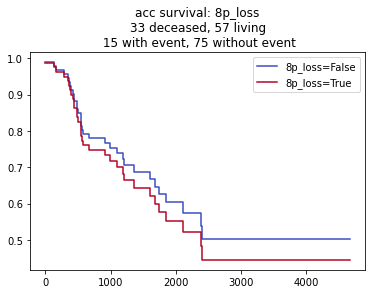

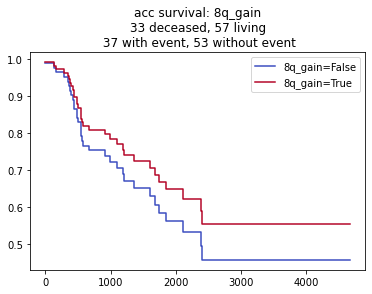

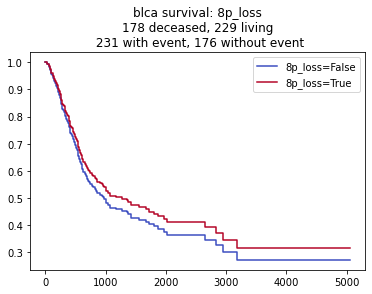

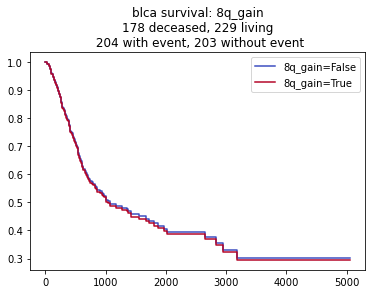

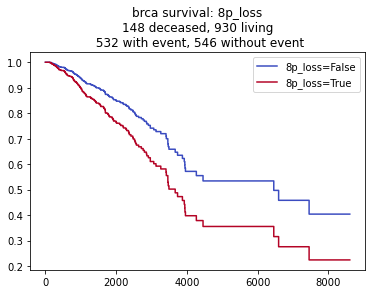

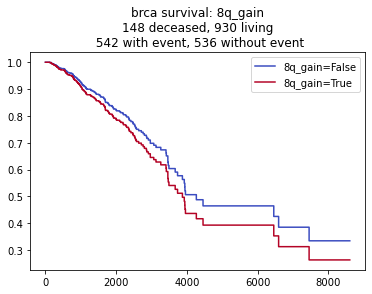

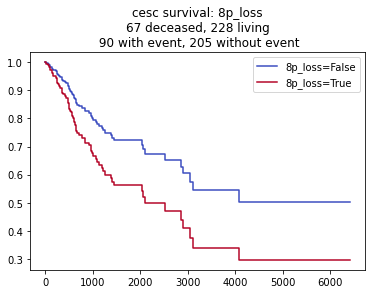

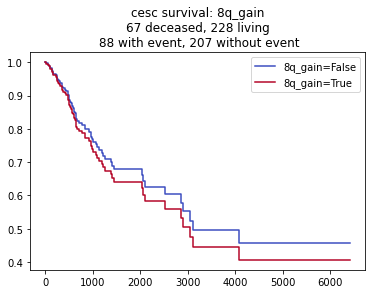

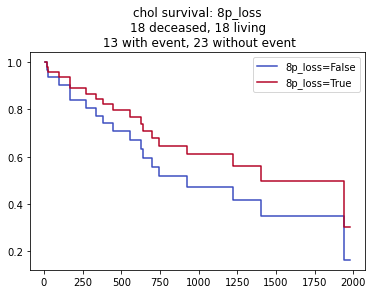

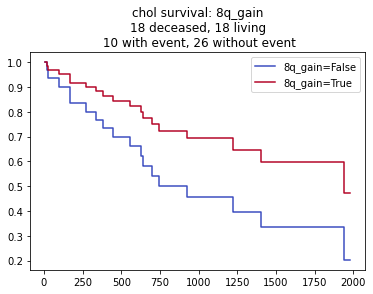

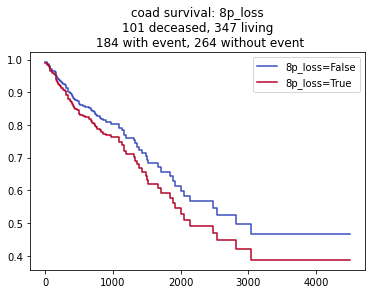

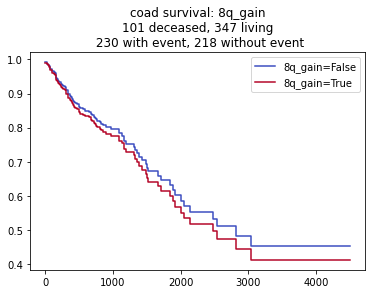

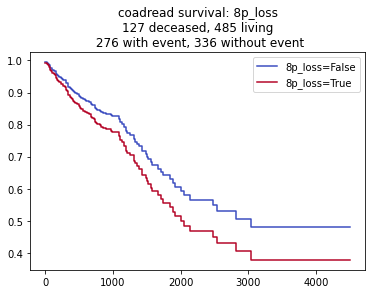

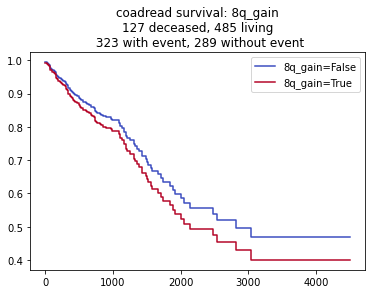

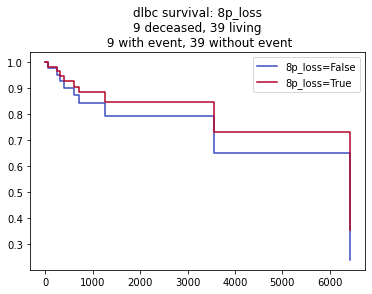

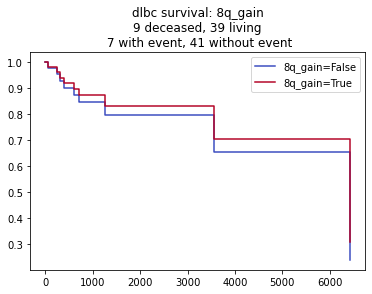

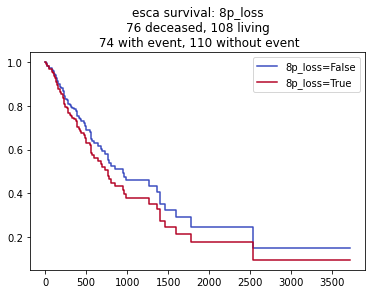

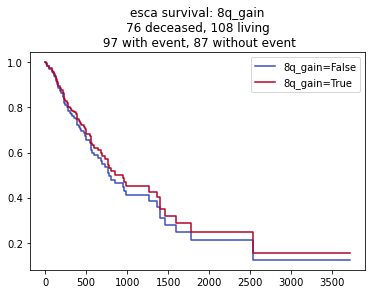

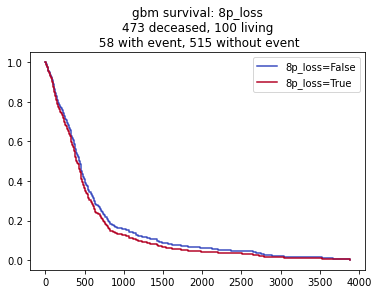

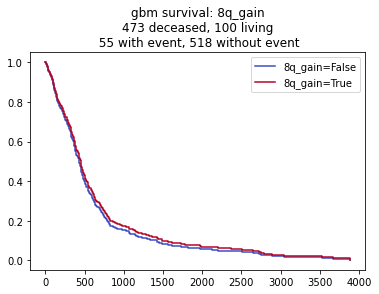

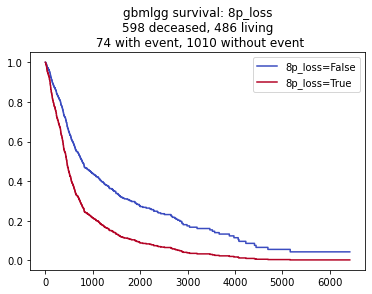

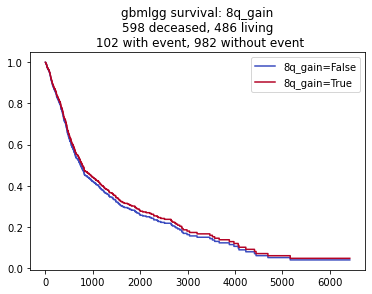

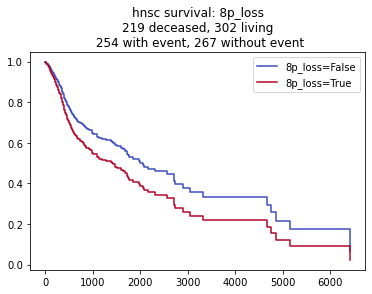

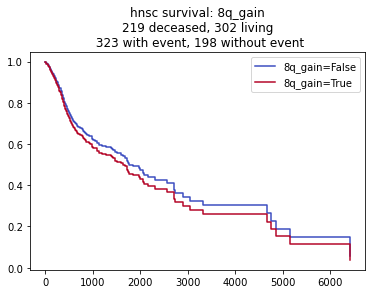

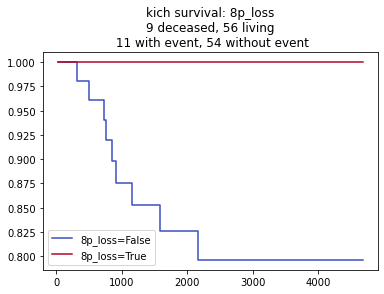

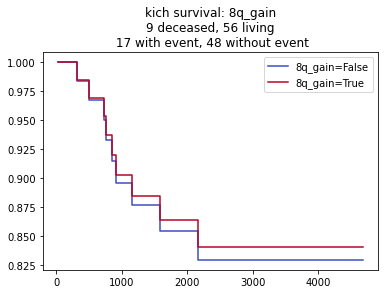

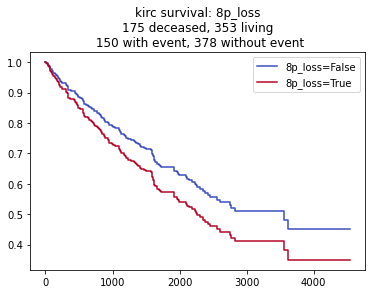

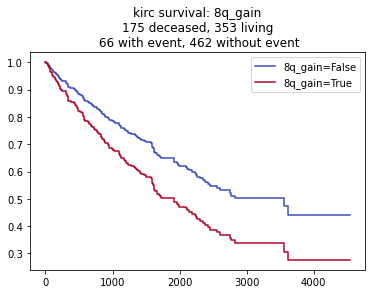

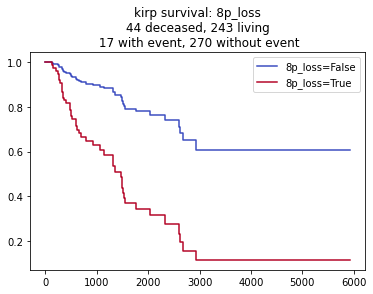

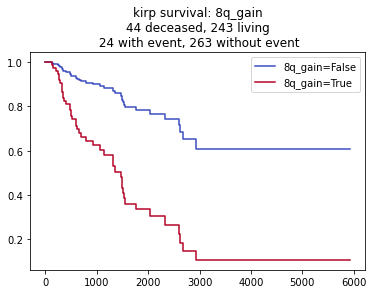

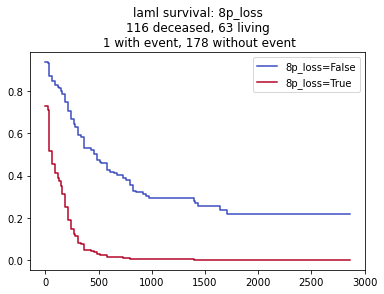

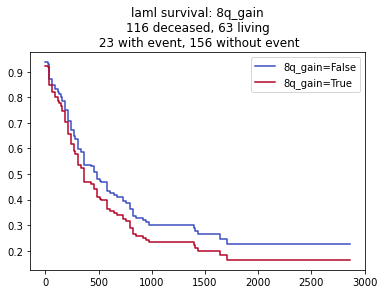

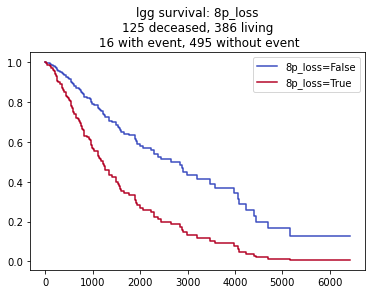

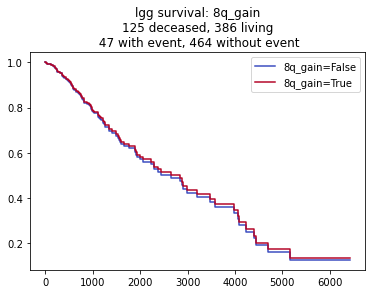

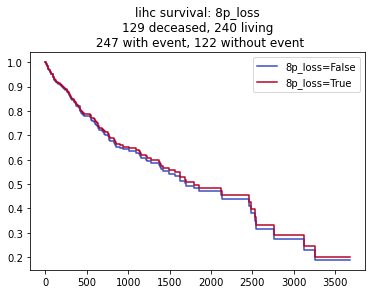

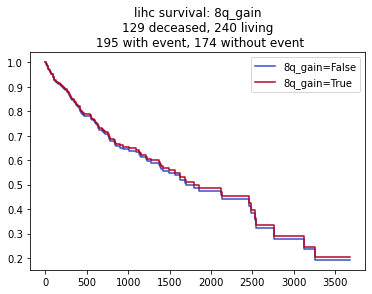

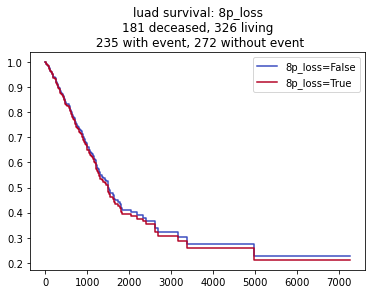

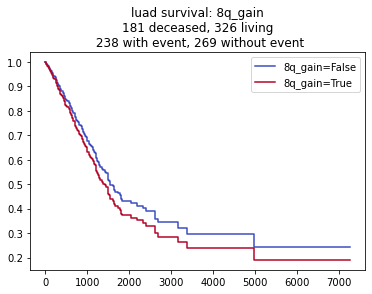

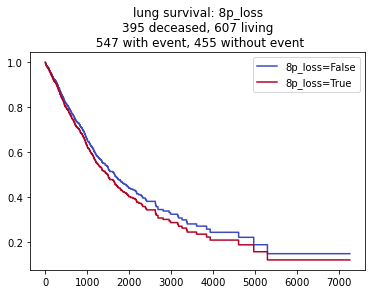

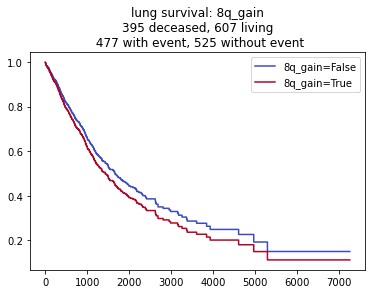

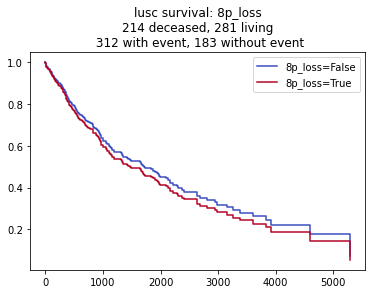

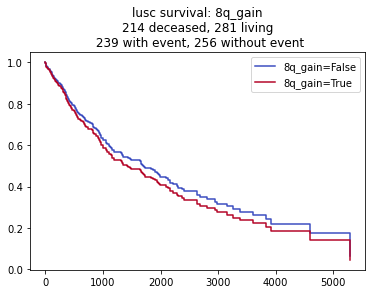

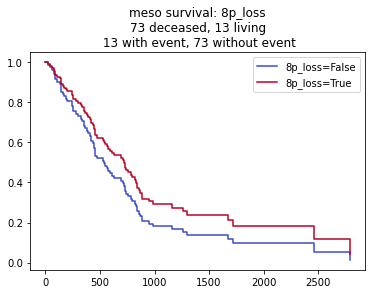

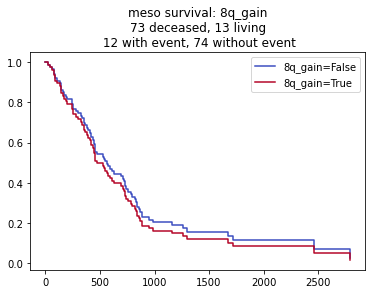

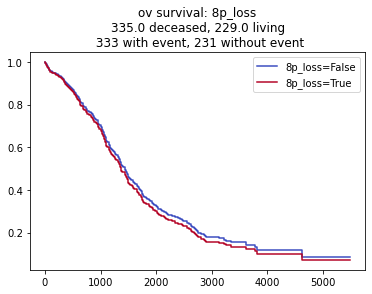

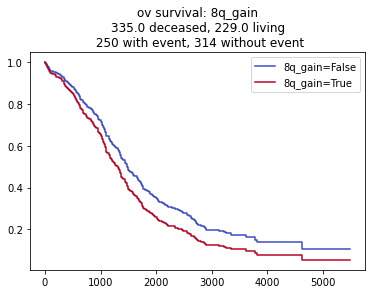

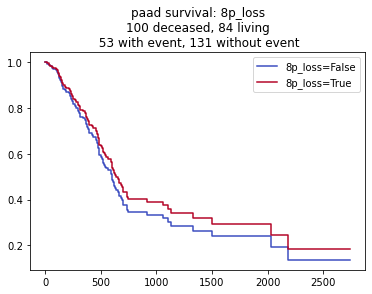

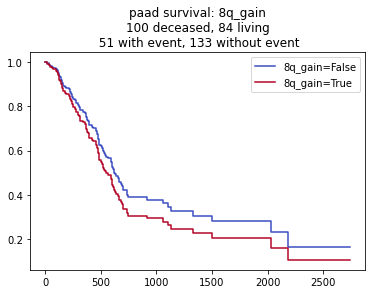

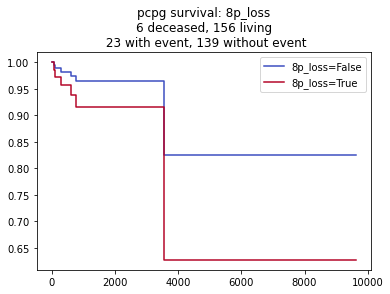

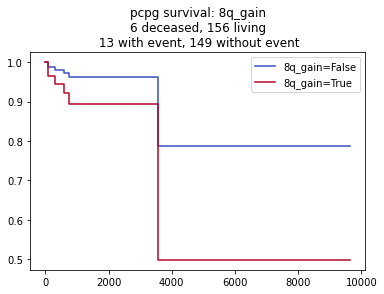

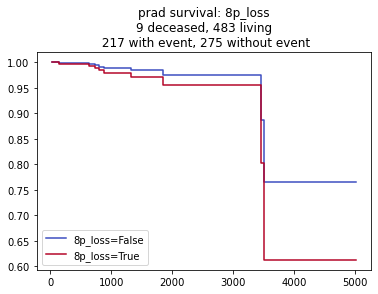

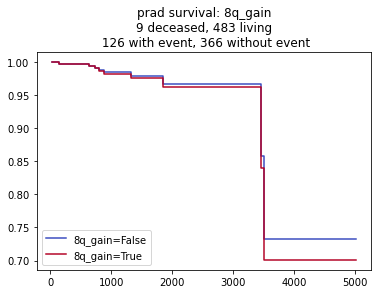

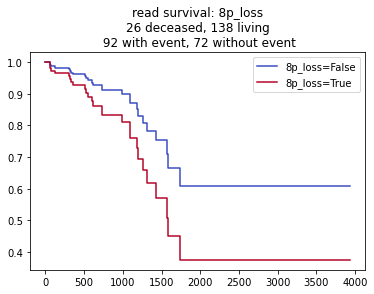

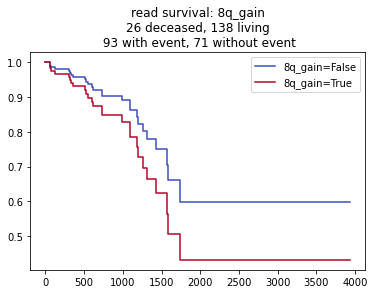

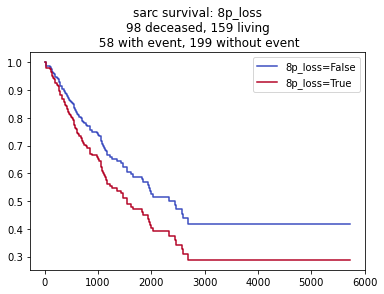

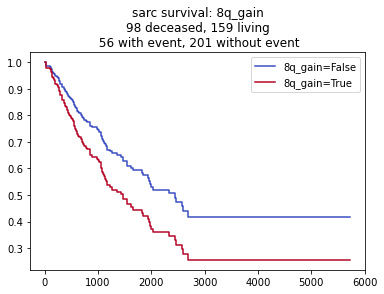

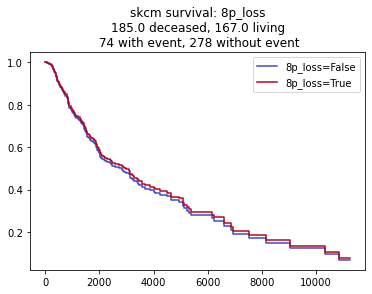

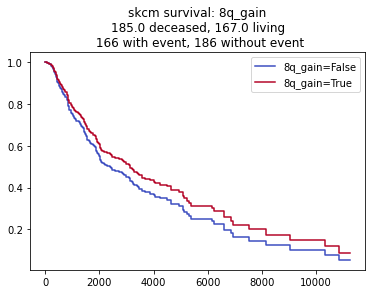

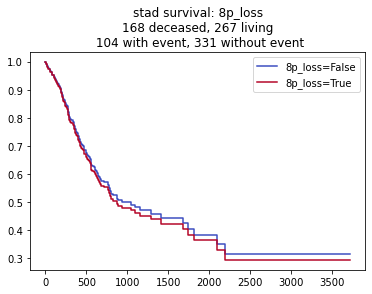

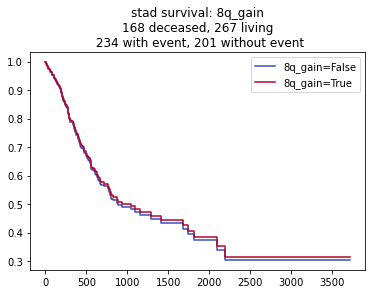

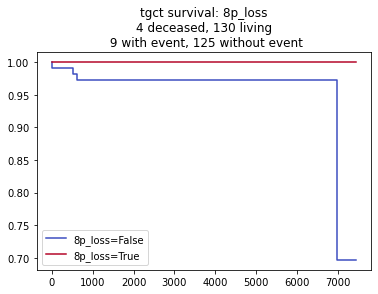

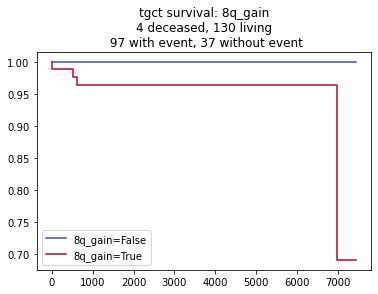

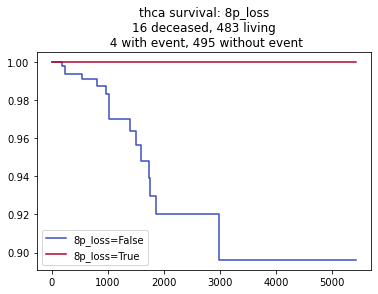

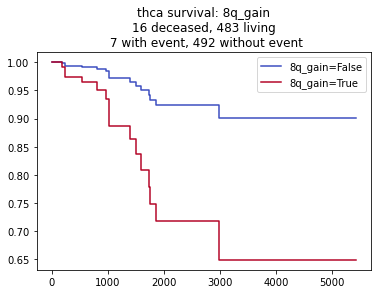

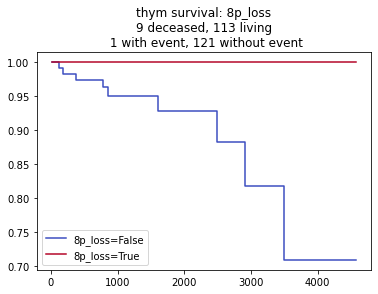

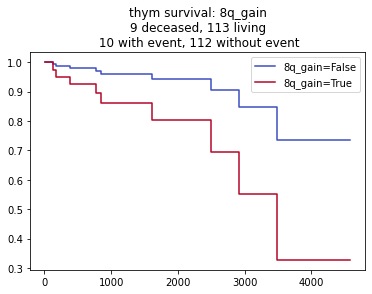

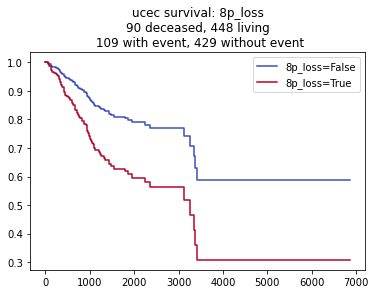

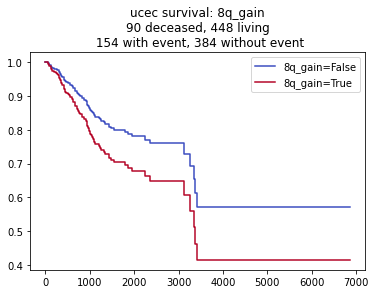

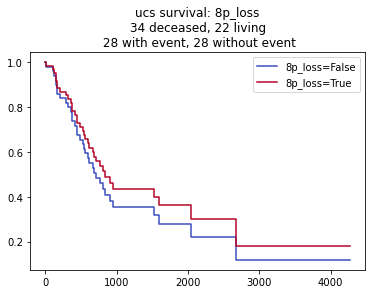

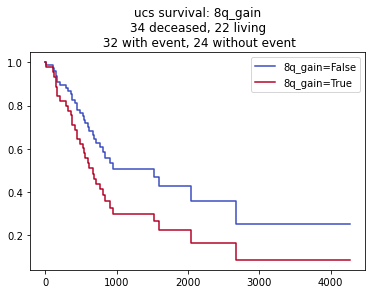

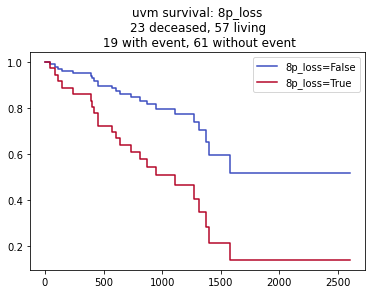

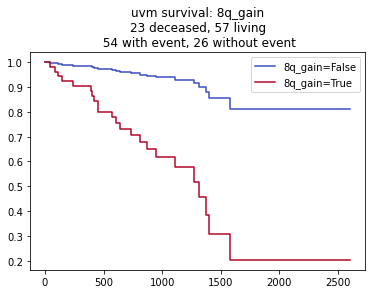

In [6]:
for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    for cnv_col in ["8p_loss", "8q_gain"]:
        sel_df = df[["death", "days_to_last_contact_or_death", cnv_col]]
        plot_single_var_survival(cancer_type, sel_df, cnv_col)

## Plot multiple variables

In [7]:
def plot_multi_var_survival(cancer_type, df, cnv_cols):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(cancer_type)
    cph.print_summary()
#     print(lifelines.statistics.proportional_hazard_test(cph, df))
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_8p_loss = df["8p_loss"].sum()
    no_8p_loss = df["8p_loss"].size - has_8p_loss
    
    has_8q_gain = df["8q_gain"].sum()
    no_8q_gain = df["8q_gain"].size - has_8q_gain
    
    plot_title = f"{cancer_type} survival: Chromosome 8\n{deceased_count} deceased, {living_count} living" +\
        f"\n{has_8p_loss} with 8p_loss, {no_8p_loss} without" +\
        f"\n{has_8q_gain} with 8q_gain, {no_8q_gain} without"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_cols, 
        values=[[a, b] for a in [True, False] for b in [True, False]],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

acc


<lifelines.CoxPHFitter: fitted with 90 total observations, 57 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 90
number of events observed = 33
   partial log-likelihood = -131.97
         time fit was run = 2022-02-17 16:55:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.04       1.04       0.47            -0.88             0.96                 0.41                 2.61
8q_gain    -0.27       0.76       0.39            -1.04             0.49                 0.35                 1.63

              z    p   -log2(p)
covariate                      
8p_loss    0.08 0.94       0.10
8q_gain   -0.71 0.48       1.06
---
Concordance = 0.52
Partial AIC = 267.94
log-likelihood ratio test = 0.62 on 2 df
-log2(p) of ll-ratio test = 0.45

blca


<lifelines.CoxPHFitter: fitted with 407 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 407
number of events observed = 178
   partial log-likelihood = -950.26
         time fit was run = 2022-02-17 16:55:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.13       0.87       0.15            -0.43             0.16                 0.65                 1.18
8q_gain     0.04       1.05       0.15            -0.25             0.34                 0.78                 1.41

              z    p   -log2(p)
covariate                      
8p_loss   -0.89 0.37       1.42
8q_gain    0.29 0.77       0.38
---
Concordance = 0.51
Partial AIC = 1904.53
log-likelihood ratio test = 0.79 on 2 df
-log2(p) of ll-ratio test = 0.57

brca


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -830.52
         time fit was run = 2022-02-17 16:55:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.48       1.62       0.18             0.13             0.83                 1.14                 2.30
8q_gain     0.07       1.07       0.17            -0.27             0.40                 0.77                 1.50

             z    p   -log2(p)
covariate                     
8p_loss   2.71 0.01       7.19
8q_gain   0.40 0.69       0.53
---
Concordance = 0.57
Partial AIC = 1665.04
log-likelihood ratio test = 9.04 on 2 df
-log2(p) of ll-ratio test = 6.52

cesc


<lifelines.CoxPHFitter: fitted with 295 total observations, 228 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 295
number of events observed = 67
   partial log-likelihood = -319.48
         time fit was run = 2022-02-17 16:55:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.57       1.76       0.25             0.08             1.05                 1.09                 2.85
8q_gain     0.11       1.11       0.27            -0.42             0.63                 0.66                 1.88

             z    p   -log2(p)
covariate                     
8p_loss   2.30 0.02       5.55
8q_gain   0.40 0.69       0.54
---
Concordance = 0.57
Partial AIC = 642.95
log-likelihood ratio test = 5.19 on 2 df
-log2(p) of ll-ratio test = 3.74

chol


<lifelines.CoxPHFitter: fitted with 36 total observations, 18 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 36
number of events observed = 18
   partial log-likelihood = -51.13
         time fit was run = 2022-02-17 16:55:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.58       0.56       0.62            -1.78             0.63                 0.17                 1.88
8q_gain    -0.88       0.41       0.64            -2.15             0.38                 0.12                 1.46

              z    p   -log2(p)
covariate                      
8p_loss   -0.94 0.35       1.52
8q_gain   -1.37 0.17       2.56
---
Concordance = 0.62
Partial AIC = 106.26
log-likelihood ratio test = 2.80 on 2 df
-log2(p) of ll-ratio test = 2.02

coad


<lifelines.CoxPHFitter: fitted with 448 total observations, 347 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 448
number of events observed = 101
   partial log-likelihood = -535.90
         time fit was run = 2022-02-17 16:55:20 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.21       1.23       0.22            -0.22             0.63                 0.80                 1.88
8q_gain     0.03       1.03       0.22            -0.39             0.46                 0.68                 1.58

             z    p   -log2(p)
covariate                     
8p_loss   0.96 0.34       1.56
8q_gain   0.16 0.88       0.19
---
Concordance = 0.52
Partial AIC = 1075.80
log-likelihood ratio test = 1.24 on 2 df
-log2(p) of ll-ratio test = 0.89

coadread


<lifelines.CoxPHFitter: fitted with 612 total observations, 485 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 612
number of events observed = 127
   partial log-likelihood = -705.01
         time fit was run = 2022-02-17 16:55:20 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.25       1.28       0.19            -0.13             0.62                 0.88                 1.86
8q_gain     0.10       1.11       0.19            -0.27             0.48                 0.76                 1.62

             z    p   -log2(p)
covariate                     
8p_loss   1.29 0.20       2.33
8q_gain   0.54 0.59       0.76
---
Concordance = 0.54
Partial AIC = 1414.02
log-likelihood ratio test = 2.80 on 2 df
-log2(p) of ll-ratio test = 2.02

dlbc


<lifelines.CoxPHFitter: fitted with 48 total observations, 39 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 48
number of events observed = 9
   partial log-likelihood = -26.18
         time fit was run = 2022-02-17 16:55:20 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.29       0.75       1.22            -2.68             2.10                 0.07                 8.17
8q_gain    -0.12       0.89       1.17            -2.41             2.17                 0.09                 8.79

              z    p   -log2(p)
covariate                      
8p_loss   -0.24 0.81       0.30
8q_gain   -0.10 0.92       0.12
---
Concordance = 0.50
Partial AIC = 56.35
log-likelihood ratio test = 0.11 on 2 df
-log2(p) of ll-ratio test = 0.08

esca


<lifelines.CoxPHFitter: fitted with 184 total observations, 108 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 184
number of events observed = 76
   partial log-likelihood = -328.11
         time fit was run = 2022-02-17 16:55:20 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.21       1.24       0.24            -0.26             0.68                 0.77                 1.97
8q_gain    -0.10       0.91       0.23            -0.55             0.35                 0.58                 1.42

              z    p   -log2(p)
covariate                      
8p_loss    0.89 0.37       1.42
8q_gain   -0.43 0.67       0.58
---
Concordance = 0.53
Partial AIC = 660.23
log-likelihood ratio test = 0.99 on 2 df
-log2(p) of ll-ratio test = 0.72

gbm


<lifelines.CoxPHFitter: fitted with 573 total observations, 100 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 573
number of events observed = 473
   partial log-likelihood = -2529.75
         time fit was run = 2022-02-17 16:55:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.11       1.11       0.18            -0.24             0.45                 0.79                 1.57
8q_gain    -0.07       0.94       0.15            -0.36             0.22                 0.70                 1.25

              z    p   -log2(p)
covariate                      
8p_loss    0.60 0.55       0.87
8q_gain   -0.45 0.65       0.62
---
Concordance = 0.51
Partial AIC = 5063.50
log-likelihood ratio test = 0.70 on 2 df
-log2(p) of ll-ratio test = 0.51

gbmlgg


<lifelines.CoxPHFitter: fitted with 1084 total observations, 486 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1084
number of events observed = 598
   partial log-likelihood = -3634.29
         time fit was run = 2022-02-17 16:55:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.62       1.86       0.14             0.34             0.90                 1.41                 2.45
8q_gain    -0.03       0.97       0.13            -0.28             0.22                 0.75                 1.24

              z      p   -log2(p)
covariate                        
8p_loss    4.41 <0.005      16.54
8q_gain   -0.26   0.79       0.34
---
Concordance = 0.52
Partial AIC = 7272.58
log-likelihood ratio test = 15.81 on 2 df
-log2(p) of ll-ratio test = 11.40

hnsc


<lifelines.CoxPHFitter: fitted with 521 total observations, 302 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 521
number of events observed = 219
   partial log-likelihood = -1201.57
         time fit was run = 2022-02-17 16:55:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.31       1.37       0.14             0.03             0.59                 1.04                 1.81
8q_gain     0.02       1.02       0.14            -0.26             0.31                 0.77                 1.36

             z    p   -log2(p)
covariate                     
8p_loss   2.20 0.03       5.19
8q_gain   0.16 0.87       0.20
---
Concordance = 0.55
Partial AIC = 2407.14
log-likelihood ratio test = 5.59 on 2 df
-log2(p) of ll-ratio test = 4.03

kich


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column 8p_loss have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, '8p_loss'].var())
>>> print(df.loc[~events, '8p_loss'].var())

A very low variance means that the column 8p_loss completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.378. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

<lifelines.CoxPHFitter: fitted with 65 total observations, 56 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 65
number of events observed = 9
   partial log-likelihood = -33.17
         time fit was run = 2022-02-17 16:55:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss   -17.23       0.00       0.49           -18.20           -16.27                 0.00                 0.00
8q_gain    -0.36       0.70       0.77            -1.87             1.15                 0.15                 3.17

               z      p   -log2(p)
covariate                         
8p_loss   -35.04 <0.005     891.01
8q_gain    -0.47   0.64       0.64
---
Concordance = 0.63
Partial AIC = 70.33
log-likelihood ratio test = 3.99 on 2 df
-log2(p) of ll-ratio test = 2.88

kirc


<lifelines.CoxPHFitter: fitted with 528 total observations, 353 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 528
number of events observed = 175
   partial log-likelihood = -982.40
         time fit was run = 2022-02-17 16:55:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.22       1.24       0.16            -0.10             0.53                 0.90                 1.71
8q_gain     0.39       1.48       0.22            -0.03             0.81                 0.97                 2.26

             z    p   -log2(p)
covariate                     
8p_loss   1.34 0.18       2.47
8q_gain   1.82 0.07       3.86
---
Concordance = 0.54
Partial AIC = 1968.81
log-likelihood ratio test = 6.07 on 2 df
-log2(p) of ll-ratio test = 4.38

kirp


<lifelines.CoxPHFitter: fitted with 287 total observations, 243 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 287
number of events observed = 44
   partial log-likelihood = -202.19
         time fit was run = 2022-02-17 16:55:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     1.22       3.37       0.48             0.28             2.15                 1.33                 8.58
8q_gain     1.30       3.67       0.42             0.47             2.13                 1.61                 8.38

             z      p   -log2(p)
covariate                       
8p_loss   2.55   0.01       6.55
8q_gain   3.08 <0.005       8.93
---
Concordance = 0.64
Partial AIC = 408.38
log-likelihood ratio test = 16.65 on 2 df
-log2(p) of ll-ratio test = 12.01

laml


<lifelines.CoxPHFitter: fitted with 179 total observations, 63 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 179
number of events observed = 116
   partial log-likelihood = -524.38
         time fit was run = 2022-02-17 16:55:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     1.59       4.91       0.18             1.24             1.94                 3.46                 6.97
8q_gain     0.20       1.23       0.24            -0.27             0.68                 0.76                 1.98

             z      p   -log2(p)
covariate                       
8p_loss   8.90 <0.005      60.68
8q_gain   0.84   0.40       1.32
---
Concordance = 0.51
Partial AIC = 1052.77
log-likelihood ratio test = 2.10 on 2 df
-log2(p) of ll-ratio test = 1.51

lgg


<lifelines.CoxPHFitter: fitted with 511 total observations, 386 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 511
number of events observed = 125
   partial log-likelihood = -622.84
         time fit was run = 2022-02-17 16:55:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.88       2.42       0.29             0.31             1.46                 1.37                 4.28
8q_gain    -0.05       0.95       0.25            -0.54             0.44                 0.58                 1.55

              z      p   -log2(p)
covariate                        
8p_loss    3.03 <0.005       8.70
8q_gain   -0.20   0.84       0.25
---
Concordance = 0.52
Partial AIC = 1249.68
log-likelihood ratio test = 3.44 on 2 df
-log2(p) of ll-ratio test = 2.48

lihc


<lifelines.CoxPHFitter: fitted with 369 total observations, 240 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 369
number of events observed = 129
   partial log-likelihood = -657.47
         time fit was run = 2022-02-17 16:55:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.04       0.96       0.20            -0.42             0.35                 0.66                 1.42
8q_gain    -0.02       0.98       0.19            -0.39             0.34                 0.68                 1.41

              z    p   -log2(p)
covariate                      
8p_loss   -0.18 0.85       0.23
8q_gain   -0.12 0.90       0.14
---
Concordance = 0.50
Partial AIC = 1318.94
log-likelihood ratio test = 0.07 on 2 df
-log2(p) of ll-ratio test = 0.05

luad


<lifelines.CoxPHFitter: fitted with 507 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 507
number of events observed = 181
   partial log-likelihood = -966.31
         time fit was run = 2022-02-17 16:55:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.01       1.01       0.15            -0.29             0.31                 0.75                 1.37
8q_gain     0.16       1.17       0.15            -0.14             0.46                 0.87                 1.58

             z    p   -log2(p)
covariate                     
8p_loss   0.09 0.93       0.10
8q_gain   1.04 0.30       1.76
---
Concordance = 0.53
Partial AIC = 1936.62
log-likelihood ratio test = 1.18 on 2 df
-log2(p) of ll-ratio test = 0.85

lung


<lifelines.CoxPHFitter: fitted with 1002 total observations, 607 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1002
number of events observed = 395
   partial log-likelihood = -2377.04
         time fit was run = 2022-02-17 16:55:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.09       1.09       0.10            -0.12             0.29                 0.89                 1.33
8q_gain     0.13       1.14       0.10            -0.07             0.33                 0.93                 1.39

             z    p   -log2(p)
covariate                     
8p_loss   0.83 0.41       1.29
8q_gain   1.29 0.20       2.35
---
Concordance = 0.53
Partial AIC = 4758.07
log-likelihood ratio test = 2.69 on 2 df
-log2(p) of ll-ratio test = 1.94

lusc


<lifelines.CoxPHFitter: fitted with 495 total observations, 281 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 495
number of events observed = 214
   partial log-likelihood = -1136.95
         time fit was run = 2022-02-17 16:55:23 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.09       1.10       0.14            -0.19             0.38                 0.83                 1.46
8q_gain     0.11       1.11       0.14            -0.16             0.38                 0.85                 1.46

             z    p   -log2(p)
covariate                     
8p_loss   0.65 0.51       0.96
8q_gain   0.79 0.43       1.22
---
Concordance = 0.53
Partial AIC = 2277.91
log-likelihood ratio test = 1.14 on 2 df
-log2(p) of ll-ratio test = 0.83

meso


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:947: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.CoxPHFitter: fitted with 86 total observations, 13 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 86
number of events observed = 73
   partial log-likelihood = -263.31
         time fit was run = 2022-02-17 16:55:23 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.32       0.73       0.35            -1.01             0.37                 0.36                 1.45
8q_gain     0.12       1.13       0.33            -0.52             0.77                 0.60                 2.15

              z    p   -log2(p)
covariate                      
8p_loss   -0.91 0.36       1.46
8q_gain    0.38 0.70       0.51
---
Concordance = 0.53
Partial AIC = 530.62
log-likelihood ratio test = 1.07 on 2 df
-log2(p) of ll-ratio test = 0.77

ov


<lifelines.CoxPHFitter: fitted with 564 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 564
number of events observed = 335
   partial log-likelihood = -1806.35
         time fit was run = 2022-02-17 16:55:23 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.04       1.04       0.11            -0.17             0.26                 0.84                 1.29
8q_gain     0.25       1.28       0.11             0.03             0.47                 1.03                 1.59

             z    p   -log2(p)
covariate                     
8p_loss   0.38 0.71       0.50
8q_gain   2.26 0.02       5.37
---
Concordance = 0.55
Partial AIC = 3616.70
log-likelihood ratio test = 5.50 on 2 df
-log2(p) of ll-ratio test = 3.97

paad


<lifelines.CoxPHFitter: fitted with 184 total observations, 84 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 184
number of events observed = 100
   partial log-likelihood = -443.96
         time fit was run = 2022-02-17 16:55:23 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.26       0.77       0.24            -0.74             0.22                 0.48                 1.24
8q_gain     0.32       1.37       0.24            -0.16             0.79                 0.86                 2.21

              z    p   -log2(p)
covariate                      
8p_loss   -1.08 0.28       1.83
8q_gain    1.31 0.19       2.40
---
Concordance = 0.55
Partial AIC = 891.92
log-likelihood ratio test = 2.33 on 2 df
-log2(p) of ll-ratio test = 1.68

pcpg


<lifelines.CoxPHFitter: fitted with 162 total observations, 156 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 162
number of events observed = 6
   partial log-likelihood = -24.41
         time fit was run = 2022-02-17 16:55:23 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     1.00       2.72       0.86            -0.68             2.68                 0.51                14.59
8q_gain     1.24       3.46       1.11            -0.94             3.42                 0.39                30.72

             z    p   -log2(p)
covariate                     
8p_loss   1.17 0.24       2.04
8q_gain   1.11 0.27       1.92
---
Concordance = 0.68
Partial AIC = 52.83
log-likelihood ratio test = 1.87 on 2 df
-log2(p) of ll-ratio test = 1.35

prad


<lifelines.CoxPHFitter: fitted with 492 total observations, 483 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 492
number of events observed = 9
   partial log-likelihood = -41.78
         time fit was run = 2022-02-17 16:55:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.63       1.89       0.62            -0.58             1.85                 0.56                 6.37
8q_gain    -0.08       0.92       0.68            -1.41             1.25                 0.24                 3.50

              z    p   -log2(p)
covariate                      
8p_loss    1.02 0.31       1.71
8q_gain   -0.12 0.91       0.14
---
Concordance = 0.53
Partial AIC = 87.55
log-likelihood ratio test = 0.81 on 2 df
-log2(p) of ll-ratio test = 0.58

read


<lifelines.CoxPHFitter: fitted with 164 total observations, 138 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 164
number of events observed = 26
   partial log-likelihood = -103.25
         time fit was run = 2022-02-17 16:55:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.61       1.83       0.40            -0.18             1.39                 0.83                 4.03
8q_gain     0.35       1.42       0.46            -0.54             1.25                 0.58                 3.47

             z    p   -log2(p)
covariate                     
8p_loss   1.51 0.13       2.92
8q_gain   0.77 0.44       1.18
---
Concordance = 0.65
Partial AIC = 210.49
log-likelihood ratio test = 3.44 on 2 df
-log2(p) of ll-ratio test = 2.48

sarc


<lifelines.CoxPHFitter: fitted with 257 total observations, 159 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 257
number of events observed = 98
   partial log-likelihood = -475.59
         time fit was run = 2022-02-17 16:55:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.33       1.39       0.24            -0.13             0.79                 0.88                 2.21
8q_gain     0.43       1.53       0.23            -0.03             0.88                 0.97                 2.41

             z    p   -log2(p)
covariate                     
8p_loss   1.40 0.16       2.64
8q_gain   1.84 0.07       3.92
---
Concordance = 0.58
Partial AIC = 955.18
log-likelihood ratio test = 5.48 on 2 df
-log2(p) of ll-ratio test = 3.95

skcm


<lifelines.CoxPHFitter: fitted with 352 total observations, 167 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 352
number of events observed = 185
   partial log-likelihood = -922.63
         time fit was run = 2022-02-17 16:55:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.04       0.96       0.16            -0.36             0.29                 0.70                 1.33
8q_gain    -0.18       0.84       0.15            -0.47             0.12                 0.63                 1.12

              z    p   -log2(p)
covariate                      
8p_loss   -0.22 0.82       0.28
8q_gain   -1.18 0.24       2.07
---
Concordance = 0.52
Partial AIC = 1849.26
log-likelihood ratio test = 1.47 on 2 df
-log2(p) of ll-ratio test = 1.06

stad


<lifelines.CoxPHFitter: fitted with 435 total observations, 267 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 435
number of events observed = 168
   partial log-likelihood = -904.00
         time fit was run = 2022-02-17 16:55:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.05       1.06       0.18            -0.29             0.40                 0.75                 1.50
8q_gain    -0.03       0.97       0.15            -0.33             0.27                 0.72                 1.31

              z    p   -log2(p)
covariate                      
8p_loss    0.31 0.76       0.40
8q_gain   -0.21 0.84       0.26
---
Concordance = 0.51
Partial AIC = 1812.00
log-likelihood ratio test = 0.13 on 2 df
-log2(p) of ll-ratio test = 0.10

tgct


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column 8p_loss have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, '8p_loss'].var())
>>> print(df.loc[~events, '8p_loss'].var())

A very low variance means that the column 8p_loss completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.514. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

<lifelines.CoxPHFitter: fitted with 134 total observations, 130 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 134
number of events observed = 4
   partial log-likelihood = -14.27
         time fit was run = 2022-02-17 16:55:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss   -14.68       0.00       0.82           -16.28           -13.08                 0.00                 0.00
8q_gain    16.30   1.20e+07       0.60            15.11            17.48             3.66e+06             3.91e+07

               z      p   -log2(p)
covariate                         
8p_loss   -18.00 <0.005     238.23
8q_gain    26.96 <0.005     529.23
---
Concordance = 0.65
Partial AIC = 32.54
log-likelihood ratio test = 2.73 on 2 df
-log2(p) of ll-ratio test = 1.97

thca


<lifelines.CoxPHFitter: fitted with 499 total observations, 483 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 499
number of events observed = 16
   partial log-likelihood = -83.16
         time fit was run = 2022-02-17 16:55:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss   -12.94       0.00       0.71           -14.34           -11.54                 0.00                 0.00
8q_gain     1.43       4.17       1.18            -0.88             3.74                 0.41                41.94

               z      p   -log2(p)
covariate                         
8p_loss   -18.11 <0.005     240.98
8q_gain     1.21   0.23       2.15
---
Concordance = 0.56
Partial AIC = 170.32
log-likelihood ratio test = 1.40 on 2 df
-log2(p) of ll-ratio test = 1.01

thym


<lifelines.CoxPHFitter: fitted with 122 total observations, 113 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 122
number of events observed = 9
   partial log-likelihood = -33.33
         time fit was run = 2022-02-17 16:55:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss   -12.90       0.00       1.12           -15.10           -10.69                 0.00                 0.00
8q_gain     1.28       3.61       0.74            -0.16             2.73                 0.85                15.34

               z      p   -log2(p)
covariate                         
8p_loss   -11.47 <0.005      98.79
8q_gain     1.74   0.08       3.61
---
Concordance = 0.55
Partial AIC = 70.66
log-likelihood ratio test = 2.09 on 2 df
-log2(p) of ll-ratio test = 1.51

ucec


<lifelines.CoxPHFitter: fitted with 538 total observations, 448 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 538
number of events observed = 90
   partial log-likelihood = -493.82
         time fit was run = 2022-02-17 16:55:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.71       2.04       0.24             0.25             1.18                 1.29                 3.25
8q_gain     0.28       1.32       0.23            -0.18             0.74                 0.84                 2.09

             z      p   -log2(p)
covariate                       
8p_loss   3.03 <0.005       8.66
8q_gain   1.20   0.23       2.11
---
Concordance = 0.60
Partial AIC = 991.65
log-likelihood ratio test = 12.98 on 2 df
-log2(p) of ll-ratio test = 9.36

ucs


<lifelines.CoxPHFitter: fitted with 56 total observations, 22 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 56
number of events observed = 34
   partial log-likelihood = -111.77
         time fit was run = 2022-02-17 16:55:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.22       0.80       0.34            -0.89             0.45                 0.41                 1.57
8q_gain     0.57       1.76       0.35            -0.12             1.26                 0.88                 3.52

              z    p   -log2(p)
covariate                      
8p_loss   -0.64 0.52       0.94
8q_gain    1.61 0.11       3.22
---
Concordance = 0.57
Partial AIC = 227.55
log-likelihood ratio test = 2.97 on 2 df
-log2(p) of ll-ratio test = 2.14

uvm


<lifelines.CoxPHFitter: fitted with 80 total observations, 57 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 80
number of events observed = 23
   partial log-likelihood = -75.83
         time fit was run = 2022-02-17 16:55:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.53       1.69       0.44            -0.33             1.39                 0.72                 4.01
8q_gain     1.80       6.07       0.71             0.41             3.19                 1.51                24.39

             z    p   -log2(p)
covariate                     
8p_loss   1.20 0.23       2.12
8q_gain   2.54 0.01       6.50
---
Concordance = 0.70
Partial AIC = 155.66
log-likelihood ratio test = 13.84 on 2 df
-log2(p) of ll-ratio test = 9.98

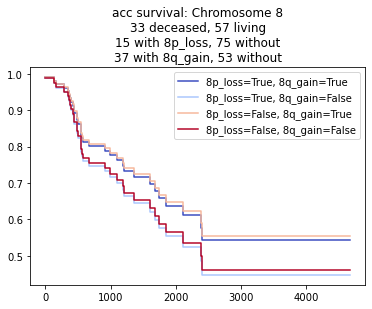

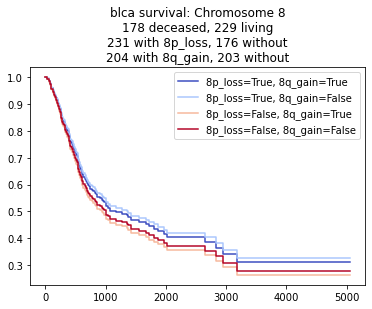

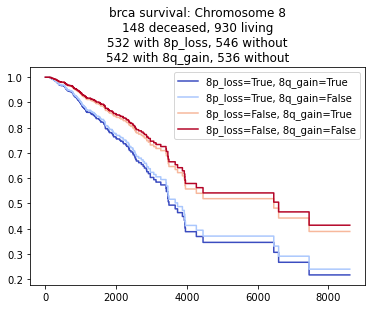

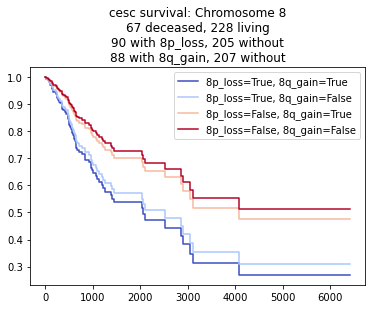

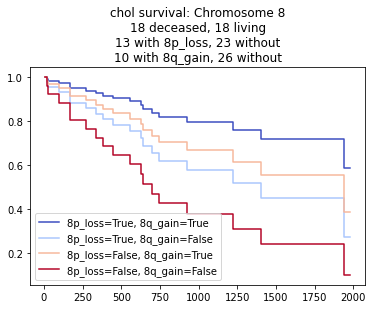

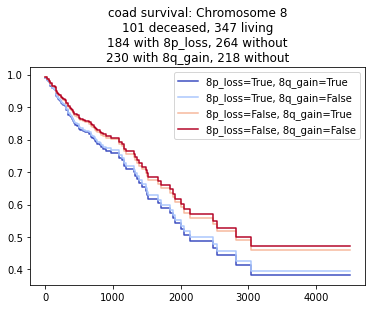

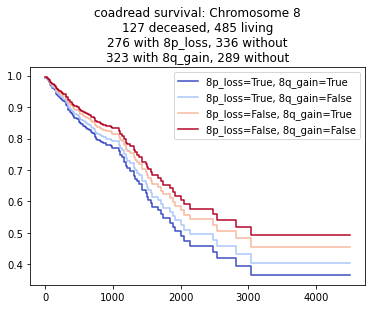

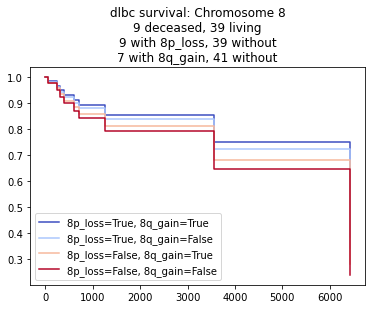

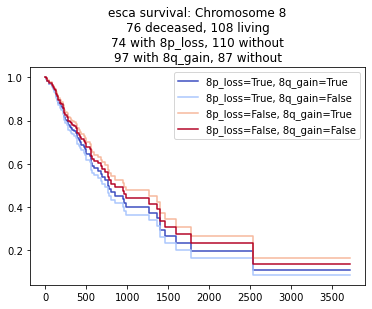

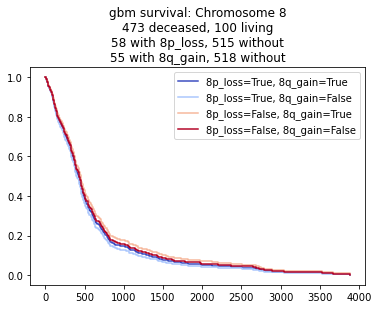

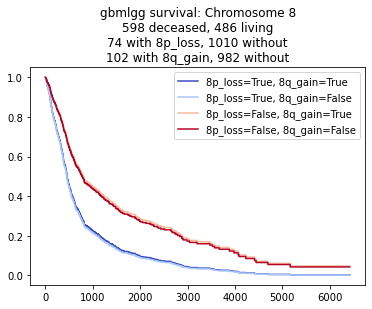

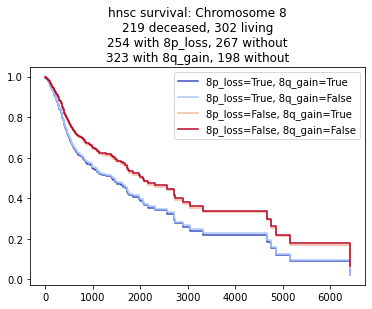

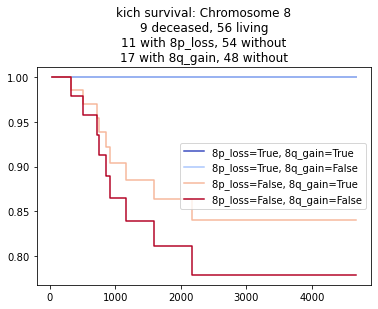

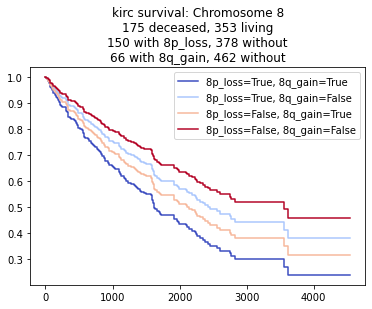

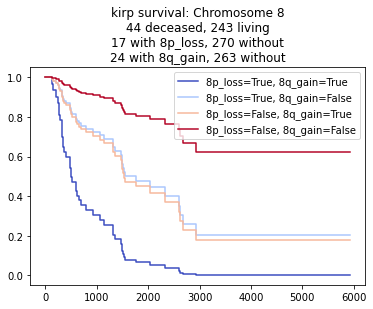

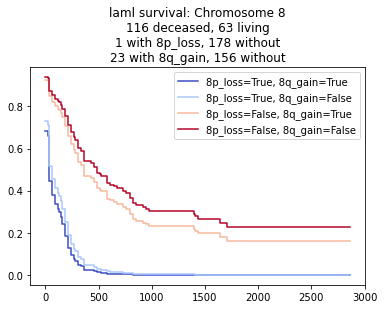

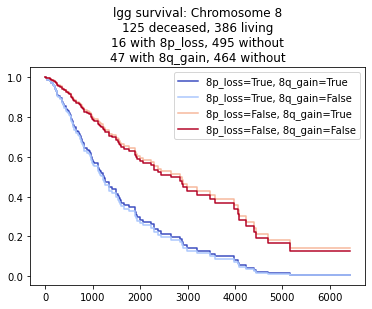

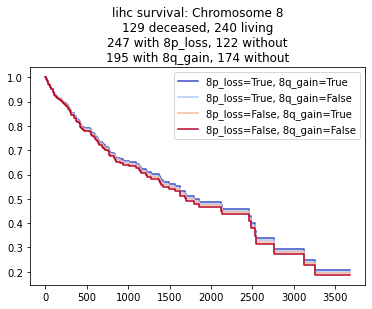

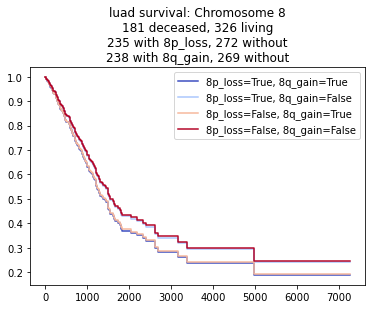

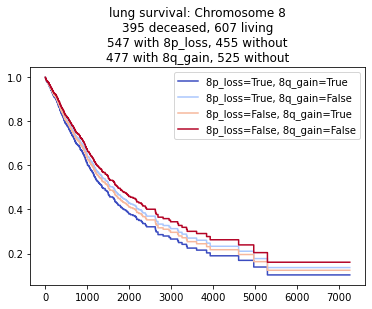

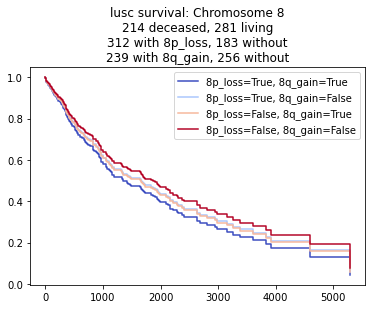

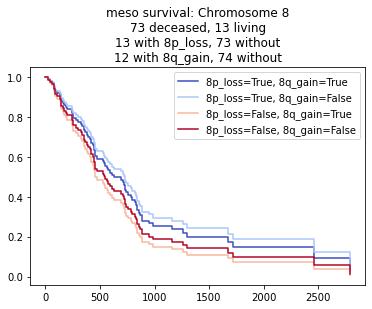

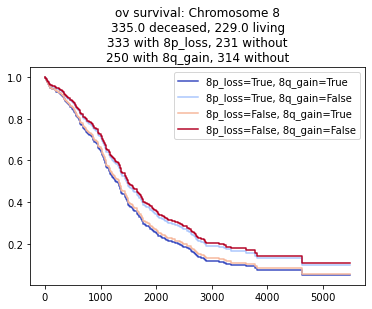

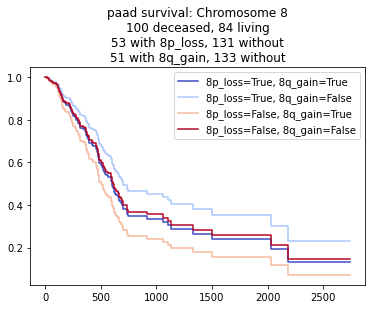

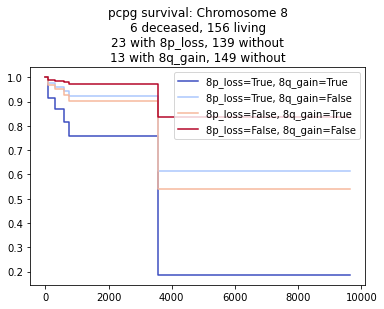

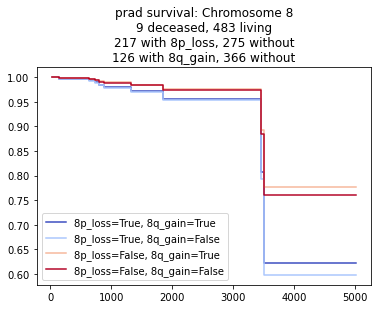

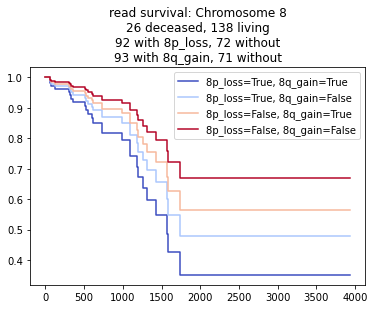

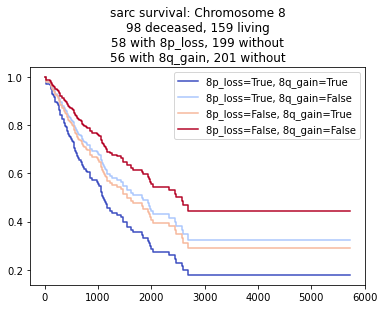

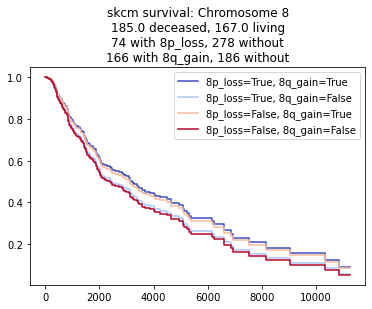

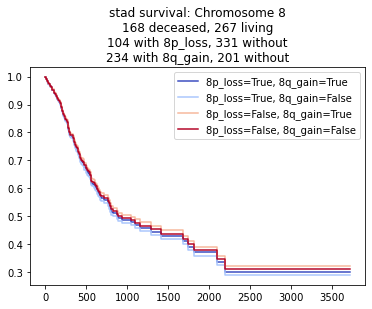

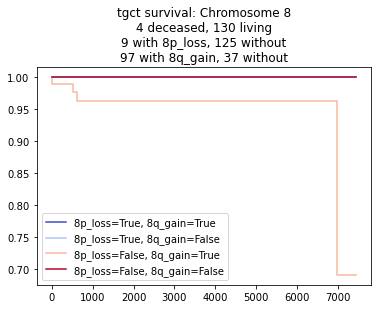

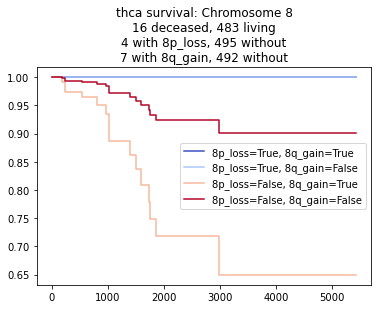

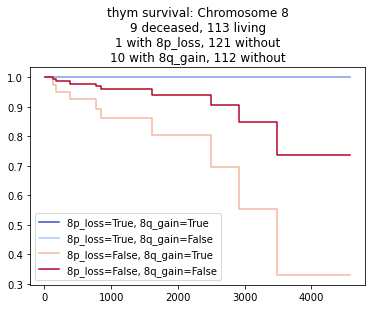

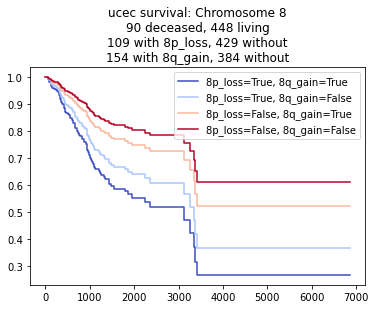

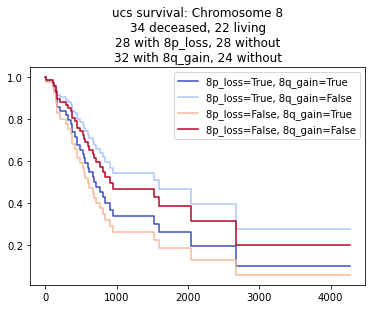

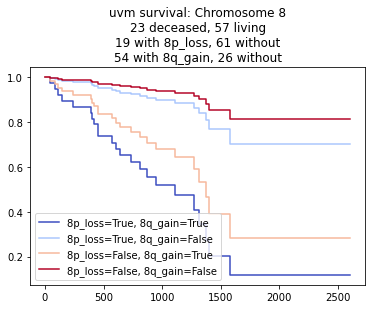

In [8]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    plot_multi_var_survival(cancer_type, df, cnv_cols)

## Plot confidence intervals

In [9]:
def plot_cis(cancer_type, df):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    return cph.plot(ax=plt.axes(label=cancer_type))

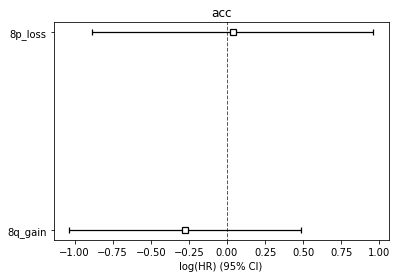

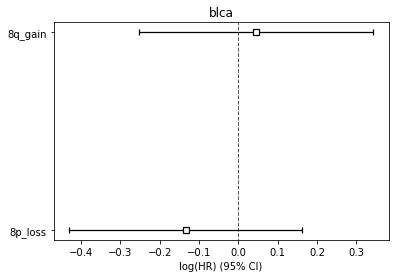

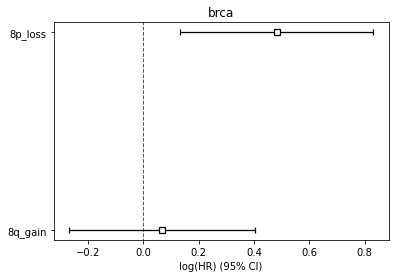

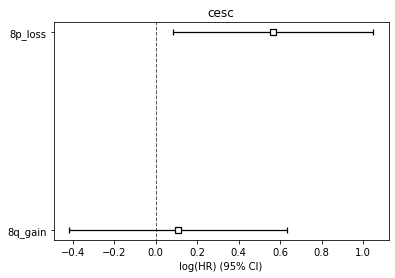

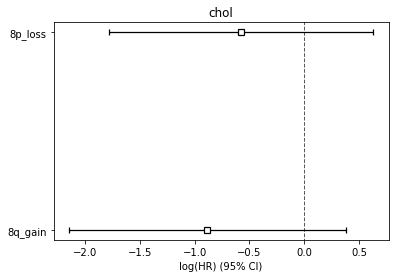

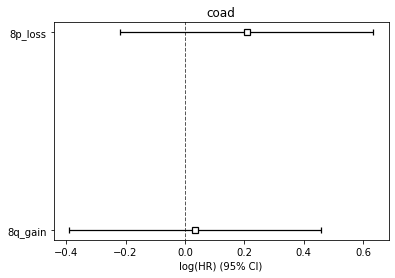

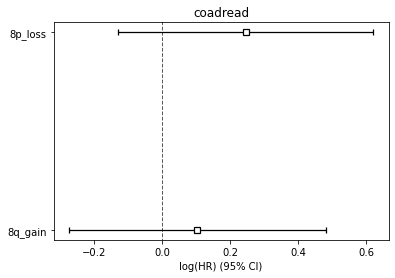

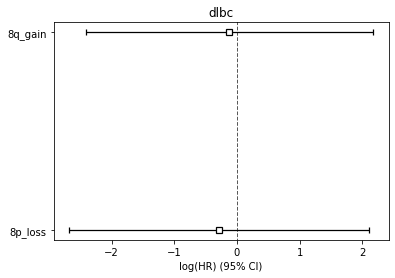

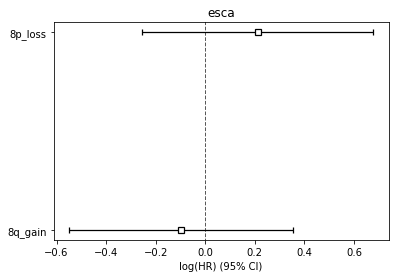

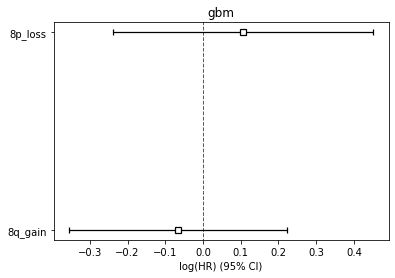

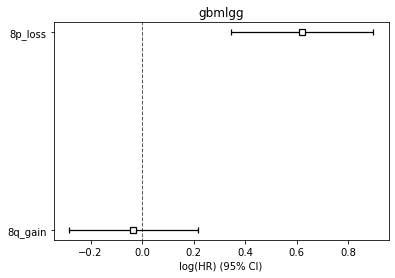

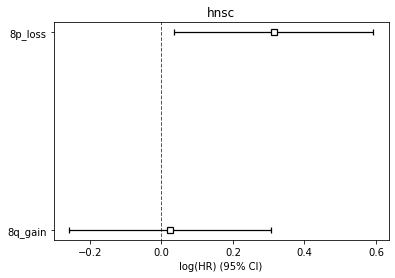

/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column 8p_loss have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, '8p_loss'].var())
>>> print(df.loc[~events, '8p_loss'].var())

A very low variance means that the column 8p_loss completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.378. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

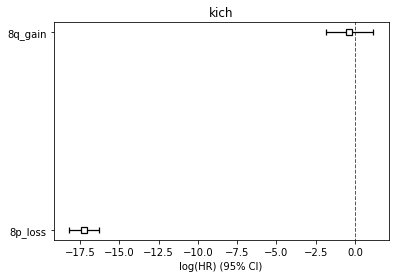

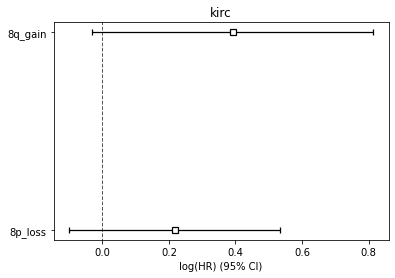

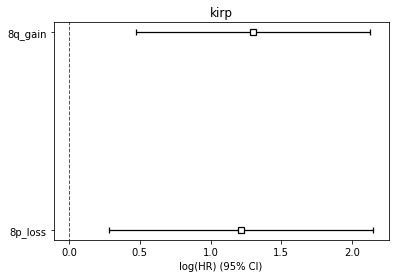

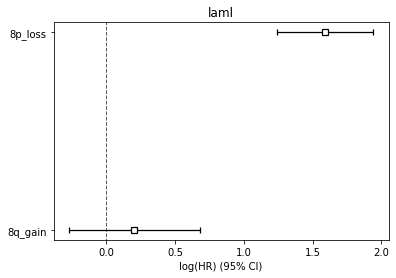

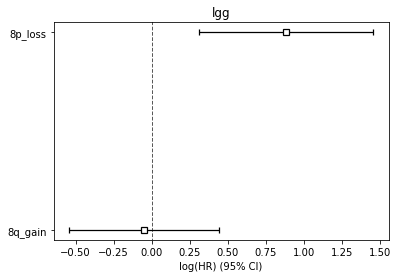

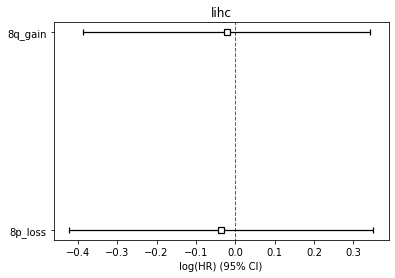

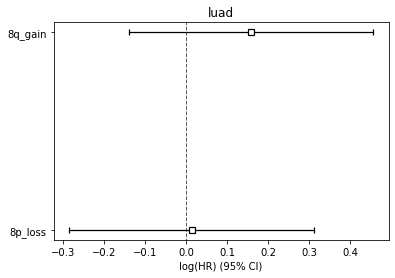

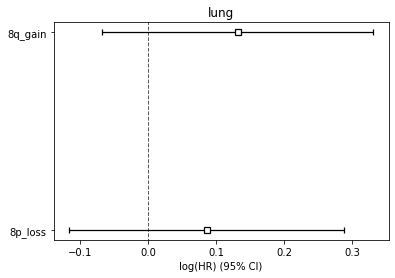

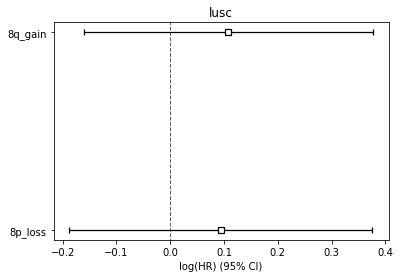

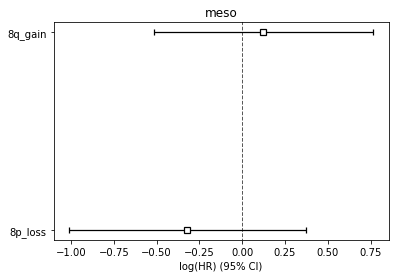

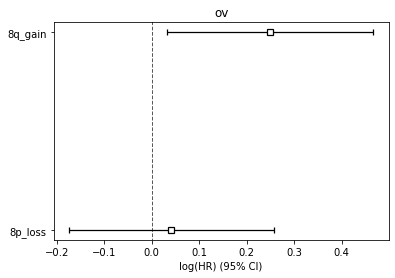

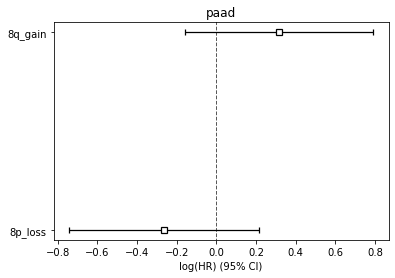

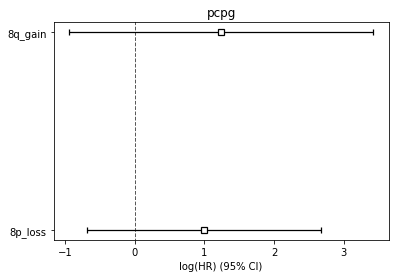

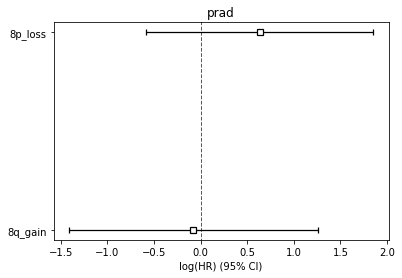

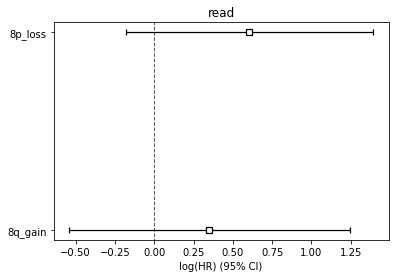

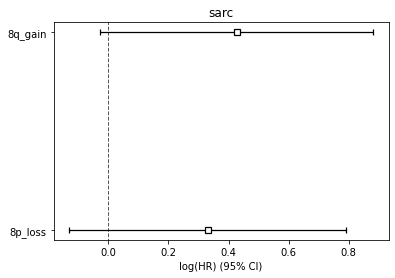

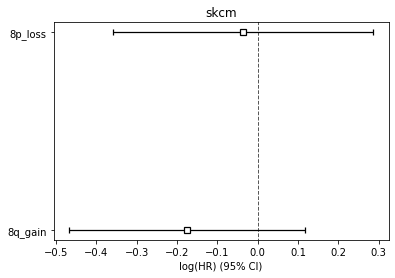

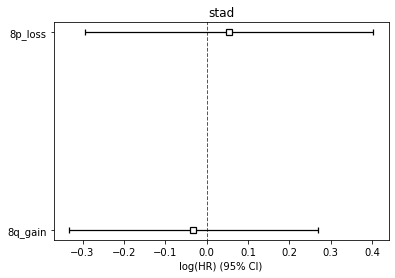

/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column 8p_loss have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, '8p_loss'].var())
>>> print(df.loc[~events, '8p_loss'].var())

A very low variance means that the column 8p_loss completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.514. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

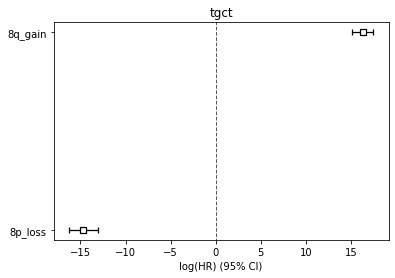

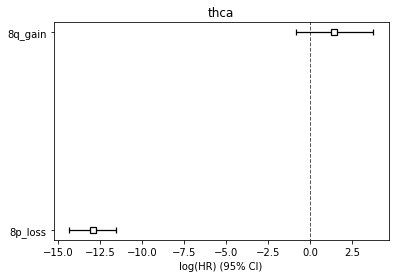

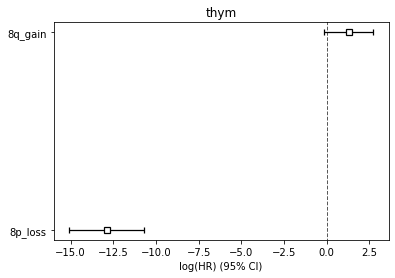

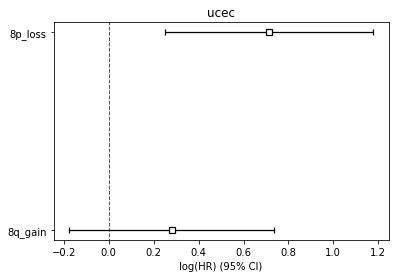

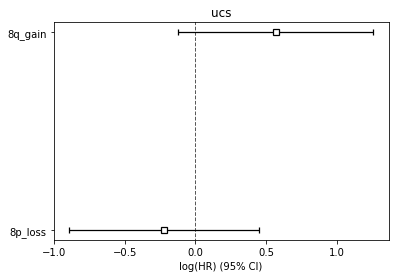

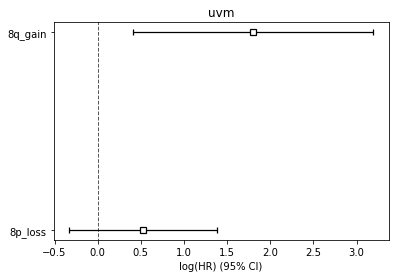

In [10]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    ax = plot_cis(cancer_type, df)
    ax.set_title(cancer_type)
    plt.show()

## Plot both vs neither

In [11]:
cancer_names = []
vital_count = []
event_count = []

def plot_both_vs_neither_survival(cancer_type, df):
    
    # Only look at samples that either have both events, or neither
    df = df[df["both"] | df["neither"]]
    df = df.assign(both_or_neither=df["both"]) # We'll take both as True, and neither as False
    df = df[["death", "days_to_last_contact_or_death", "both_or_neither"]]
    cnv_col = "both_or_neither"
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print("-----------------------------------------------------------------")
    print(f"{cancer_type} - both vs. neither")
    cph.print_summary()
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_event_count = df[cnv_col].sum()
    no_event_count = df[cnv_col].size - has_event_count
    
    for ct in [deceased_count, living_count, has_event_count, no_event_count]:
        if ct > 999:
            raise Exception("More than 3 places")
    
    # Save counts
    cancer_names.append(cancer_type)
    vital_count.append(f"{int(deceased_count):_>3} deceased/{int(living_count):_>3} living")
    event_count.append(f"{int(has_event_count):_>3} both/{int(no_event_count):_>3} neither")
    
    plot_title = f"{cancer_type} survival: {cnv_col}\n{deceased_count} deceased, {living_count} living\n {has_event_count} with event, {no_event_count} without event"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_col, 
        values=[False, True],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

-----------------------------------------------------------------
blca - both vs. neither


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['both_or_neither'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:801: RuntimeWarning: invalid value encountered in true_divide
  return (X - mean) / std


<lifelines.CoxPHFitter: fitted with 240 total observations, 141 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 240
number of events observed = 99
   partial log-likelihood = -478.23
         time fit was run = 2022-02-17 16:55:37 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither  -0.07       0.93       0.20            -0.46             0.32                 0.63                 1.38

                    z    p   -log2(p)
covariate                            
both_or_neither -0.34 0.73       0.45
---
Concordance = 0.49
Partial AIC = 958.46
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.44

-----------------------------------------------------------------
brca - both vs. neither


<lifelines.CoxPHFitter: fitted with 678 total observations, 586 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 678
number of events observed = 92
   partial log-likelihood = -474.39
         time fit was run = 2022-02-17 16:55:37 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.57       1.76       0.22             0.14             0.99                 1.15                 2.69

                   z    p   -log2(p)
covariate                           
both_or_neither 2.62 0.01       6.85
---
Concordance = 0.57
Partial AIC = 950.78
log-likelihood ratio test = 7.08 on 1 df
-log2(p) of ll-ratio test = 7.01

-----------------------------------------------------------------
cesc - both vs. neither


<lifelines.CoxPHFitter: fitted with 181 total observations, 140 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 181
number of events observed = 41
   partial log-likelihood = -179.55
         time fit was run = 2022-02-17 16:55:37 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.76       2.14       0.37             0.04             1.48                 1.04                 4.41

                   z    p   -log2(p)
covariate                           
both_or_neither 2.06 0.04       4.68
---
Concordance = 0.58
Partial AIC = 361.10
log-likelihood ratio test = 4.03 on 1 df
-log2(p) of ll-ratio test = 4.48

-----------------------------------------------------------------
chol - both vs. neither


<lifelines.CoxPHFitter: fitted with 21 total observations, 8 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 21
number of events observed = 13
   partial log-likelihood = -29.08
         time fit was run = 2022-02-17 16:55:37 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.09       1.09       0.64            -1.17             1.35                 0.31                 3.84

                   z    p   -log2(p)
covariate                           
both_or_neither 0.14 0.89       0.17
---
Concordance = 0.49
Partial AIC = 60.15
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.13

-----------------------------------------------------------------
coad - both vs. neither


<lifelines.CoxPHFitter: fitted with 290 total observations, 223 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 290
number of events observed = 67
   partial log-likelihood = -325.72
         time fit was run = 2022-02-17 16:55:37 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.23       1.26       0.24            -0.25             0.71                 0.78                 2.04

                   z    p   -log2(p)
covariate                           
both_or_neither 0.96 0.34       1.56
---
Concordance = 0.52
Partial AIC = 653.45
log-likelihood ratio test = 0.91 on 1 df
-log2(p) of ll-ratio test = 1.56

-----------------------------------------------------------------
coadread - both vs. neither


<lifelines.CoxPHFitter: fitted with 399 total observations, 316 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 399
number of events observed = 83
   partial log-likelihood = -425.26
         time fit was run = 2022-02-17 16:55:37 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.35       1.42       0.22            -0.08             0.78                 0.92                 2.19

                   z    p   -log2(p)
covariate                           
both_or_neither 1.58 0.11       3.13
---
Concordance = 0.54
Partial AIC = 852.52
log-likelihood ratio test = 2.51 on 1 df
-log2(p) of ll-ratio test = 3.14

-----------------------------------------------------------------
dlbc - both vs. neither


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column both_or_neither have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, 'both_or_neither'].var())
>>> print(df.loc[~events, 'both_or_neither'].var())

A very low variance means that the column both_or_neither completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.273. This may imply non-unique solutions to the maximu

<lifelines.CoxPHFitter: fitted with 38 total observations, 31 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 38
number of events observed = 7
   partial log-likelihood = -17.25
         time fit was run = 2022-02-17 16:55:38 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither -14.93       0.00       0.77           -16.45           -13.42                 0.00                 0.00

                     z      p   -log2(p)
covariate                               
both_or_neither -19.36 <0.005     275.04
---
Concordance = 0.54
Partial AIC = 36.49
log-likelihood ratio test = 0.86 on 1 df
-log2(p) of ll-ratio test = 1.50

-----------------------------------------------------------------
esca - both vs. neither


<lifelines.CoxPHFitter: fitted with 89 total observations, 57 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 89
number of events observed = 32
   partial log-likelihood = -109.72
         time fit was run = 2022-02-17 16:55:38 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.13       1.14       0.40            -0.65             0.91                 0.52                 2.49

                   z    p   -log2(p)
covariate                           
both_or_neither 0.33 0.74       0.44
---
Concordance = 0.51
Partial AIC = 221.45
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.43

-----------------------------------------------------------------
gbm - both vs. neither


<lifelines.CoxPHFitter: fitted with 462 total observations, 81 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 462
number of events observed = 381
   partial log-likelihood = -1956.55
         time fit was run = 2022-02-17 16:55:38 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.29       1.34       0.07             0.15             0.43                 1.17                 1.54

                   z      p   -log2(p)
covariate                             
both_or_neither 4.11 <0.005      14.60
---
Concordance = 0.50
Partial AIC = 3915.11
log-likelihood ratio test = 0.08 on 1 df
-log2(p) of ll-ratio test = 0.36

-----------------------------------------------------------------
gbmlgg - both vs. neither


<lifelines.CoxPHFitter: fitted with 912 total observations, 423 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 912
number of events observed = 489
   partial log-likelihood = -2897.00
         time fit was run = 2022-02-17 16:55:38 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.29       1.34       0.36            -0.41             0.99                 0.66                 2.69

                   z    p   -log2(p)
covariate                           
both_or_neither 0.81 0.42       1.26
---
Concordance = 0.50
Partial AIC = 5795.99
log-likelihood ratio test = 0.15 on 1 df
-log2(p) of ll-ratio test = 0.52

-----------------------------------------------------------------
hnsc - both vs. neither


<lifelines.CoxPHFitter: fitted with 330 total observations, 195 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 330
number of events observed = 135
   partial log-likelihood = -680.08
         time fit was run = 2022-02-17 16:55:38 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.39       1.48       0.18             0.04             0.74                 1.04                 2.10

                   z    p   -log2(p)
covariate                           
both_or_neither 2.18 0.03       5.09
---
Concordance = 0.56
Partial AIC = 1362.16
log-likelihood ratio test = 4.74 on 1 df
-log2(p) of ll-ratio test = 5.08

-----------------------------------------------------------------
kirc - both vs. neither


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['both_or_neither'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:801: RuntimeWarning: invalid value encountered in true_divide
  return (X - mean) / std


<lifelines.CoxPHFitter: fitted with 392 total observations, 269 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 392
number of events observed = 123
   partial log-likelihood = -656.66
         time fit was run = 2022-02-17 16:55:39 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.63       1.87       0.27             0.10             1.16                 1.10                 3.18

                   z    p   -log2(p)
covariate                           
both_or_neither 2.33 0.02       5.66
---
Concordance = 0.54
Partial AIC = 1315.31
log-likelihood ratio test = 4.93 on 1 df
-log2(p) of ll-ratio test = 5.25

-----------------------------------------------------------------
kirp - both vs. neither


<lifelines.CoxPHFitter: fitted with 252 total observations, 219 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 252
number of events observed = 33
   partial log-likelihood = -148.07
         time fit was run = 2022-02-17 16:55:39 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   2.13       8.38       0.64             0.87             3.38                 2.38                29.46

                   z      p   -log2(p)
covariate                             
both_or_neither 3.31 <0.005      10.09
---
Concordance = 0.53
Partial AIC = 298.13
log-likelihood ratio test = 4.84 on 1 df
-log2(p) of ll-ratio test = 5.17

-----------------------------------------------------------------
lgg - both vs. neither


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['both_or_neither'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:801: RuntimeWarning: invalid value encountered in true_divide
  return (X - mean) / std


<lifelines.CoxPHFitter: fitted with 450 total observations, 342 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 450
number of events observed = 108
   partial log-likelihood = -528.43
         time fit was run = 2022-02-17 16:55:39 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.86       2.36       0.13             0.61             1.11                 1.84                 3.02

                   z      p   -log2(p)
covariate                             
both_or_neither 6.81 <0.005      36.57
---
Concordance = 0.50
Partial AIC = 1058.86
log-likelihood ratio test = 0.56 on 1 df
-log2(p) of ll-ratio test = 1.14

-----------------------------------------------------------------
lihc - both vs. neither


<lifelines.CoxPHFitter: fitted with 237 total observations, 156 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 237
number of events observed = 81
   partial log-likelihood = -372.56
         time fit was run = 2022-02-17 16:55:39 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither  -0.04       0.96       0.22            -0.49             0.40                 0.62                 1.49

                    z    p   -log2(p)
covariate                            
both_or_neither -0.20 0.84       0.25
---
Concordance = 0.49
Partial AIC = 747.13
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.24

-----------------------------------------------------------------
luad - both vs. neither


<lifelines.CoxPHFitter: fitted with 292 total observations, 194 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 292
number of events observed = 98
   partial log-likelihood = -466.25
         time fit was run = 2022-02-17 16:55:39 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.16       1.17       0.20            -0.24             0.55                 0.79                 1.74

                   z    p   -log2(p)
covariate                           
both_or_neither 0.77 0.44       1.19
---
Concordance = 0.52
Partial AIC = 934.50
log-likelihood ratio test = 0.59 on 1 df
-log2(p) of ll-ratio test = 1.17

-----------------------------------------------------------------
lung - both vs. neither


<lifelines.CoxPHFitter: fitted with 556 total observations, 350 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 556
number of events observed = 206
   partial log-likelihood = -1120.33
         time fit was run = 2022-02-17 16:55:39 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.23       1.25       0.14            -0.05             0.50                 0.95                 1.65

                   z    p   -log2(p)
covariate                           
both_or_neither 1.61 0.11       3.23
---
Concordance = 0.54
Partial AIC = 2242.65
log-likelihood ratio test = 2.59 on 1 df
-log2(p) of ll-ratio test = 3.22

-----------------------------------------------------------------
lusc - both vs. neither


<lifelines.CoxPHFitter: fitted with 264 total observations, 156 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 264
number of events observed = 108
   partial log-likelihood = -511.34
         time fit was run = 2022-02-17 16:55:40 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.25       1.29       0.20            -0.14             0.64                 0.87                 1.90

                   z    p   -log2(p)
covariate                           
both_or_neither 1.27 0.20       2.29
---
Concordance = 0.54
Partial AIC = 1024.68
log-likelihood ratio test = 1.58 on 1 df
-log2(p) of ll-ratio test = 2.26

-----------------------------------------------------------------
meso - both vs. neither


<lifelines.CoxPHFitter: fitted with 65 total observations, 11 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 65
number of events observed = 54
   partial log-likelihood = -180.86
         time fit was run = 2022-02-17 16:55:40 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither  -0.24       0.79       0.29            -0.82             0.34                 0.44                 1.40

                    z    p   -log2(p)
covariate                            
both_or_neither -0.82 0.41       1.28
---
Concordance = 0.51
Partial AIC = 363.72
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.31

-----------------------------------------------------------------
ov - both vs. neither


<lifelines.CoxPHFitter: fitted with 293 total observations, 120 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 293
number of events observed = 173
   partial log-likelihood = -823.80
         time fit was run = 2022-02-17 16:55:40 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.31       1.36       0.15             0.01             0.61                 1.01                 1.83

                   z    p   -log2(p)
covariate                           
both_or_neither 2.05 0.04       4.63
---
Concordance = 0.56
Partial AIC = 1649.59
log-likelihood ratio test = 4.11 on 1 df
-log2(p) of ll-ratio test = 4.55

-----------------------------------------------------------------
paad - both vs. neither


<lifelines.CoxPHFitter: fitted with 134 total observations, 61 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 134
number of events observed = 73
   partial log-likelihood = -297.21
         time fit was run = 2022-02-17 16:55:40 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.05       1.06       0.29            -0.51             0.62                 0.60                 1.86

                   z    p   -log2(p)
covariate                           
both_or_neither 0.19 0.85       0.23
---
Concordance = 0.52
Partial AIC = 596.43
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.24

-----------------------------------------------------------------
pcpg - both vs. neither


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:947: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.CoxPHFitter: fitted with 128 total observations, 125 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 128
number of events observed = 3
   partial log-likelihood = -10.40
         time fit was run = 2022-02-17 16:55:41 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither -10.81       0.00       1.41           -13.58            -8.05                 0.00                 0.00

                    z      p   -log2(p)
covariate                              
both_or_neither -7.66 <0.005      45.65
---
Concordance = 0.50
Partial AIC = 22.80
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.16

-----------------------------------------------------------------
prad - both vs. neither


<lifelines.CoxPHFitter: fitted with 325 total observations, 318 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 325
number of events observed = 7
   partial log-likelihood = -31.22
         time fit was run = 2022-02-17 16:55:41 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.64       1.89       0.72            -0.77             2.05                 0.46                 7.73

                   z    p   -log2(p)
covariate                           
both_or_neither 0.89 0.37       1.42
---
Concordance = 0.57
Partial AIC = 64.45
log-likelihood ratio test = 0.66 on 1 df
-log2(p) of ll-ratio test = 1.26

-----------------------------------------------------------------
read - both vs. neither


<lifelines.CoxPHFitter: fitted with 109 total observations, 93 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 109
number of events observed = 16
   partial log-likelihood = -57.71
         time fit was run = 2022-02-17 16:55:41 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   1.09       2.96       0.63            -0.15             2.32                 0.86                10.21

                   z    p   -log2(p)
covariate                           
both_or_neither 1.72 0.09       3.55
---
Concordance = 0.65
Partial AIC = 117.42
log-likelihood ratio test = 3.45 on 1 df
-log2(p) of ll-ratio test = 3.98

-----------------------------------------------------------------
sarc - both vs. neither


<lifelines.CoxPHFitter: fitted with 171 total observations, 112 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 171
number of events observed = 59
   partial log-likelihood = -261.74
         time fit was run = 2022-02-17 16:55:41 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.63       1.87       0.43            -0.21             1.46                 0.81                 4.31

                   z    p   -log2(p)
covariate                           
both_or_neither 1.47 0.14       2.82
---
Concordance = 0.53
Partial AIC = 525.48
log-likelihood ratio test = 2.06 on 1 df
-log2(p) of ll-ratio test = 2.72

-----------------------------------------------------------------
skcm - both vs. neither


<lifelines.CoxPHFitter: fitted with 194 total observations, 90 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 194
number of events observed = 104
   partial log-likelihood = -451.38
         time fit was run = 2022-02-17 16:55:41 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither  -0.17       0.85       0.25            -0.65             0.32                 0.52                 1.38

                    z    p   -log2(p)
covariate                            
both_or_neither -0.67 0.50       0.99
---
Concordance = 0.50
Partial AIC = 904.75
log-likelihood ratio test = 0.48 on 1 df
-log2(p) of ll-ratio test = 1.04

-----------------------------------------------------------------
stad - both vs. neither


<lifelines.CoxPHFitter: fitted with 219 total observations, 126 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 219
number of events observed = 93
   partial log-likelihood = -436.42
         time fit was run = 2022-02-17 16:55:41 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.15       1.17       0.23            -0.30             0.61                 0.74                 1.84

                   z    p   -log2(p)
covariate                           
both_or_neither 0.66 0.51       0.97
---
Concordance = 0.52
Partial AIC = 874.84
log-likelihood ratio test = 0.43 on 1 df
-log2(p) of ll-ratio test = 0.96

-----------------------------------------------------------------
ucec - both vs. neither


/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['both_or_neither'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:801: RuntimeWarning: invalid value encountered in true_divide
  return (X - mean) / std


<lifelines.CoxPHFitter: fitted with 381 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 381
number of events observed = 55
   partial log-likelihood = -277.88
         time fit was run = 2022-02-17 16:55:42 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.89       2.44       0.30             0.31             1.48                 1.36                 4.37

                   z      p   -log2(p)
covariate                             
both_or_neither 2.98 <0.005       8.45
---
Concordance = 0.56
Partial AIC = 557.77
log-likelihood ratio test = 7.35 on 1 df
-log2(p) of ll-ratio test = 7.22

-----------------------------------------------------------------
ucs - both vs. neither


<lifelines.CoxPHFitter: fitted with 30 total observations, 10 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 30
number of events observed = 20
   partial log-likelihood = -53.18
         time fit was run = 2022-02-17 16:55:42 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   0.22       1.25       0.46            -0.68             1.13                 0.50                 3.09

                   z    p   -log2(p)
covariate                           
both_or_neither 0.48 0.63       0.66
---
Concordance = 0.52
Partial AIC = 108.35
log-likelihood ratio test = 0.22 on 1 df
-log2(p) of ll-ratio test = 0.65

-----------------------------------------------------------------
uvm - both vs. neither


<lifelines.CoxPHFitter: fitted with 45 total observations, 33 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 45
number of events observed = 12
   partial log-likelihood = -30.04
         time fit was run = 2022-02-17 16:55:42 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
both_or_neither   2.30       9.94       0.72             0.88             3.71                 2.42                40.91

                   z      p   -log2(p)
covariate                             
both_or_neither 3.18 <0.005       9.42
---
Concordance = 0.77
Partial AIC = 62.07
log-likelihood ratio test = 12.55 on 1 df
-log2(p) of ll-ratio test = 11.30

Tests failed for these cancer types:
	acc
	kich
	laml
	tgct
	thca
	thym


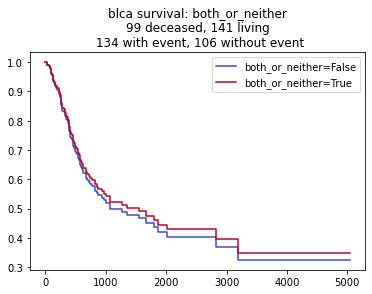

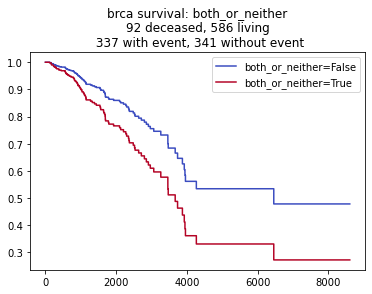

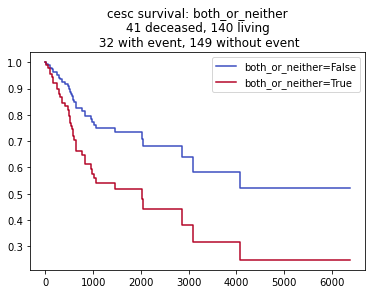

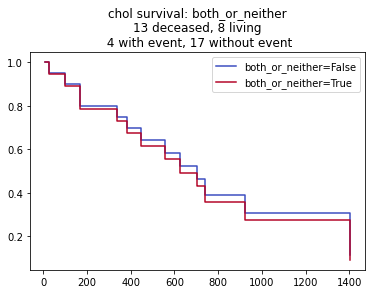

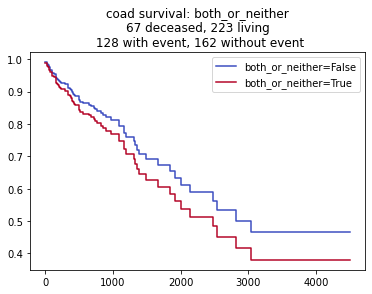

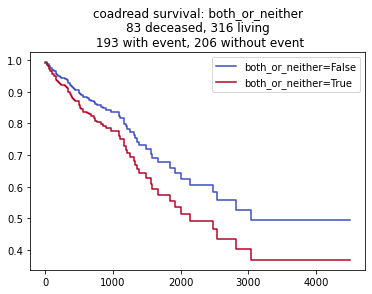

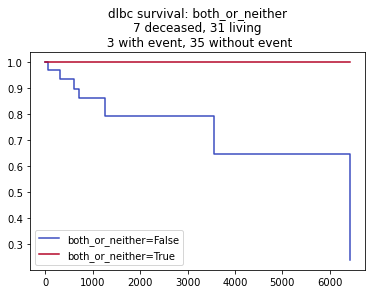

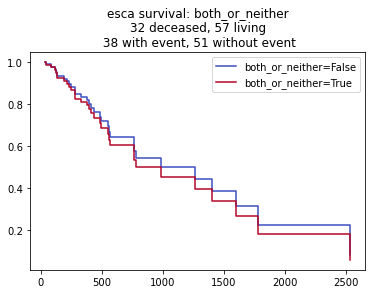

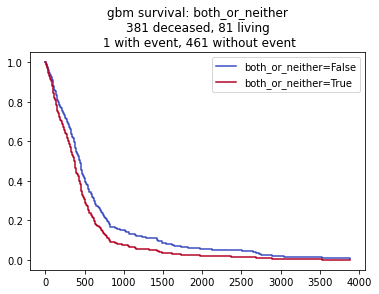

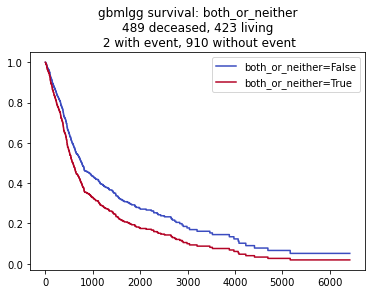

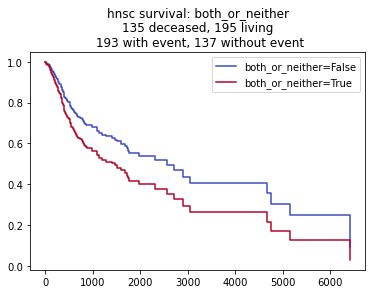

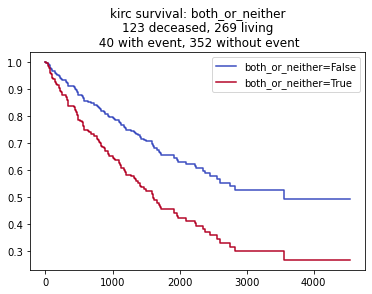

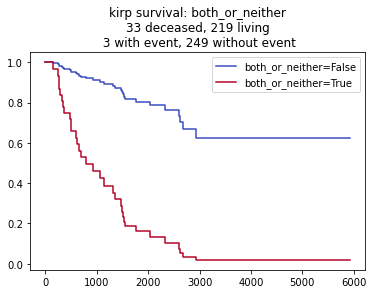

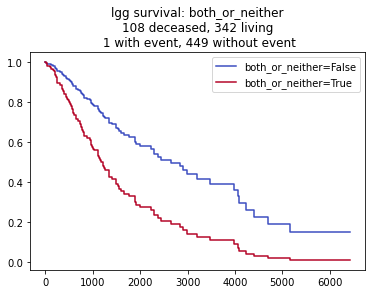

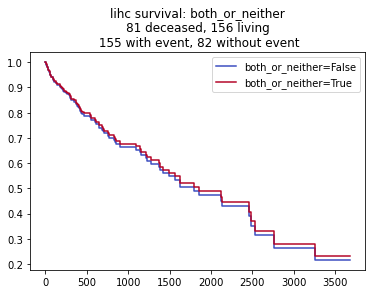

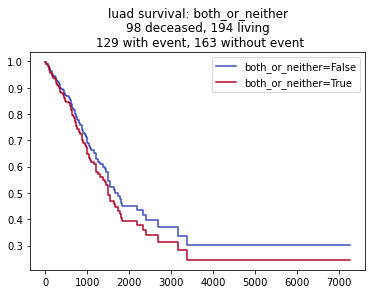

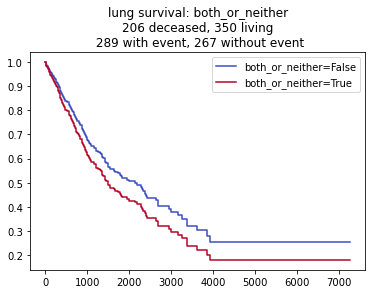

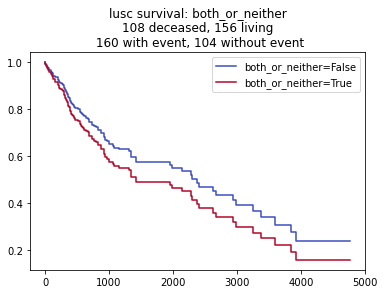

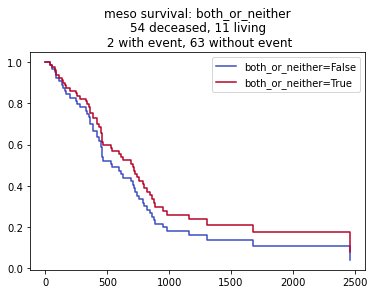

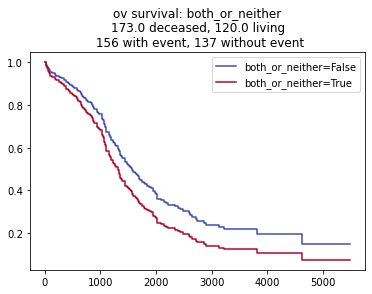

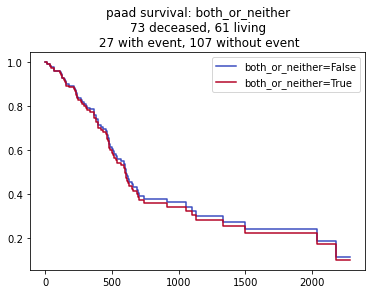

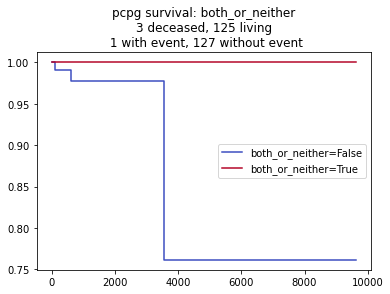

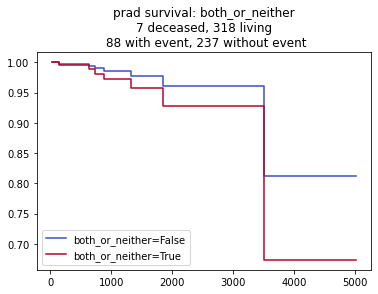

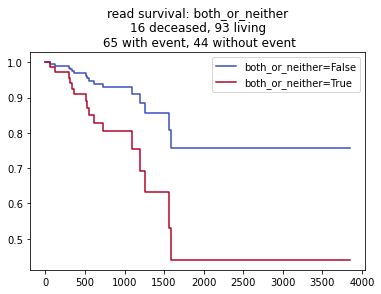

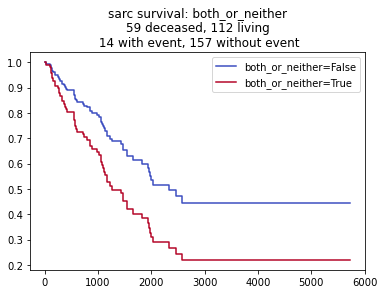

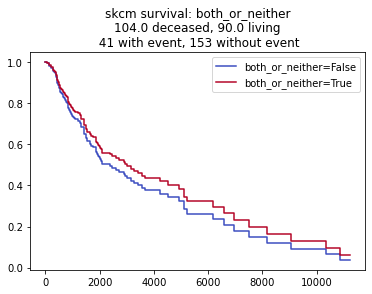

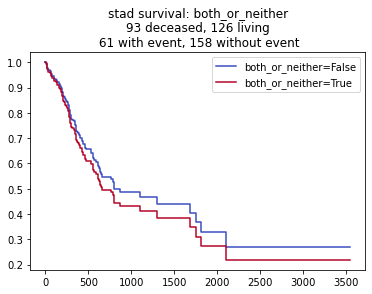

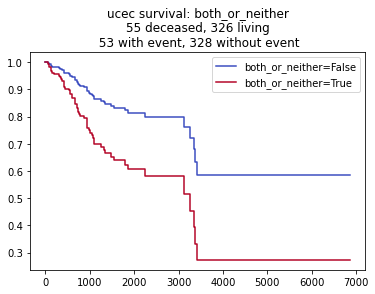

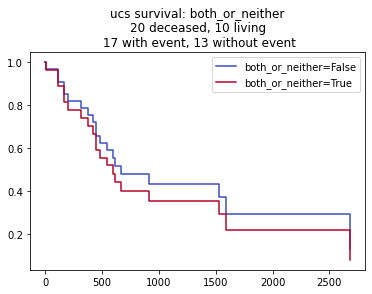

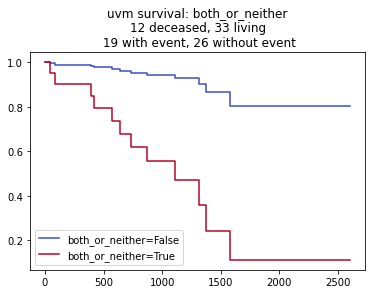

In [12]:
failed = []

for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    try:
        plot_both_vs_neither_survival(cancer_type, df)
    except lifelines.exceptions.ConvergenceError:
        failed.append(cancer_type)
        
print("Tests failed for these cancer types:")
for fail in failed:
    print(f"\t{fail}")

In [13]:
pd.DataFrame({
    "Cancer": cancer_names, 
    "Deceased/living": vital_count,
    "Both/neither": event_count
})

,Cancer,Deceased/living,Both/neither
0,blca,_99 deceased/141 living,134 both/106 neither
1,brca,_92 deceased/586 living,337 both/341 neither
2,cesc,_41 deceased/140 living,_32 both/149 neither
3,chol,_13 deceased/__8 living,__4 both/_17 neither
4,coad,_67 deceased/223 living,128 both/162 neither
5,coadread,_83 deceased/316 living,193 both/206 neither
6,dlbc,__7 deceased/_31 living,__3 both/_35 neither
7,esca,_32 deceased/_57 living,_38 both/_51 neither
8,gbm,381 deceased/_81 living,__1 both/461 neither
9,gbmlgg,489 deceased/423 living,__2 both/910 neither


In [14]:
pvals = [
    0.73,
    0.01,
    0.04,
    0.89,
    0.34,
    0.11,
    0.005,
    0.74,
    0.005,
    0.42,
    0.03,
    0.02,
    0.005,
    0.005,
    0.84,
    0.44,
    0.11,
    0.2,
    0.41,
    0.04,
    0.85,
    0.005,
    0.37,
    0.09,
    0.14,
    0.5,
    0.51,
    0.005,
    0.63,
    0.005,
]

reject, pvals_adj, alphaSidak, alphaBonf = statsmodels.stats.multitest.multipletests(
    pvals=pvals, 
    alpha=0.05, 
    method="fdr_bh"
)

In [15]:
ap = pd.DataFrame({
    "cancer_type": cancer_names,
    "adj_p": pvals_adj
}).set_index("cancer_type")

ap = ap.drop(index=["dlbc", "gbm", "kirp", "lgg", "pcpg"]).reset_index(drop=False)

In [16]:
ap

,cancer_type,adj_p
0,blca,0.822222
1,brca,0.037500
2,cesc,0.100000
3,chol,0.890000
4,coad,0.566667
5,coadread,0.220000
6,esca,0.822222
7,gbmlgg,0.600000
8,hnsc,0.090000
9,kirc,0.066667


In [17]:
def pval_plot(df, title, group_col, val_col, color_col, sig=0.05):
    
    df = df.assign(**{group_col: df[group_col].str.upper()})
    
    val_log_col = "neg_log_p"
    log_cutoff = -np.log10(sig)
    df = df.assign(**{val_log_col: - np.log10(df[val_col])})
        
    base = alt.Chart(df).mark_point().encode(
        x=alt.X(
            group_col,
            title="Cancer type",
            axis=alt.Axis(
                labelAngle=40,
            )
        ),
        y=alt.Y(
            val_log_col,
            title="-log(p)"
        ),
    )
    
    chart = base.encode(
        color=alt.Color(
            color_col,
            title="Cancer type"
        )
    )
    
    chart_text = base.transform_filter(
        alt.datum.neg_log_p >= log_cutoff
    ).mark_text(
        color="black",
        align='right',
        baseline='middle',
        dx=7,
        dy=13,
    ).encode(
        text='cancer_type',
    )


    line = alt.Chart(pd.DataFrame({
        'y': [log_cutoff],
        "label": [f"-log({sig})"]
    })).mark_rule(color="crimson").encode(
        y="y"
    )

    text = line.mark_text(
        align="right",
        dx=-260
    ).encode(
        text="label"
    )

    return (chart + chart_text + line + text).properties(title=title)

coxph_pval_plot = pval_plot(
    ap, 
#     title=[
#         "Cox Proportional Hazard test results for correlation between",
#         "survival and having either both or neither of the chr 8 events"], 
    title="Effect of 8p loss + 8q gain on patient survival",
    group_col="cancer_type", 
    val_col="adj_p", 
    color_col="cancer_type",
).\
configure_axisY(titleY=175, titleX=-35)
coxph_pval_plot

alt.LayerChart(...)

In [18]:
coxph_pval_plot.save("coxph_pval_plot.png", scale_factor=8)

In [19]:
bool(0)

False